# NBA Player Analytics Pipeline

## Necessary Imports

In [29]:
import time
import re
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5g}'.format)
from PIL import Image
import requests
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm
import requests
import matplotlib.pyplot as plt
from matplotlib.offsetbox import  OffsetImage
from matplotlib.ticker import FuncFormatter
from matplotlib import cm 
import seaborn as sns
import urllib.request
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from bs4 import BeautifulSoup
import urllib
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Webscrape player data into Dataframe

In [30]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'P',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df_players = pd.DataFrame(rows, columns=columns)

# ADD PLAYER HEIGHT
# ADD JERSEY NUMBER
# ADD POSITION
# ADD YEARS OF EXPERIENCE
# ADD AGE
# ADD CONTRACT

df_players['DATE_MATCHUP'] = df_players['GAME_DATE'].str[5:] + ' ' + df_players['MATCHUP'].str[4:]

df_players['FG2M'] = df_players.FGM - df_players.FG3M
df_players['FG2A'] = df_players.FGA - df_players.FG3A

df_players['FG2_PTS'] = df_players.FG2M * 2
df_players['FG3_PTS'] = df_players.FG3M * 3

df_players['FRAC_ATT_2PT'] = df_players.FG2A / df_players.FGA
df_players['FRAC_ATT_3PT'] = df_players.FG3A / df_players.FGA

df_players['FRAC_MK_2PT'] = df_players.FG2M / df_players.FGM
df_players['FRAC_MK_3PT'] = df_players.FG3M / df_players.FGM

df_players['FRAC_PTS_2PT'] = df_players.FG2_PTS / df_players.PTS
df_players['FRAC_PTS_3PT'] = df_players.FG3_PTS / df_players.PTS
df_players['FRAC_PTS_FT'] = df_players.FTM / df_players.PTS

df_players = df_players.fillna(0)

df_players.head()

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,FANTASY_PTS,VIDEO_AVAILABLE,DATE_MATCHUP,FG2M,FG2A,FG2_PTS,FG3_PTS,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT
0,22022,203476,Gorgui Dieng,1610612759,SAS,San Antonio Spurs,0022200729,2023-01-25,SAS @ LAL,L,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,01-25 @ LAL,0,0,0,0,0,0,0,0,0,0,0
1,22022,1630233,Nathan Knight,1610612750,MIN,Minnesota Timberwolves,0022200724,2023-01-25,MIN @ NOP,W,3,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2,2,-4,3.5,1,01-25 @ NOP,1,1,2,0,1,0,1,0,1,0,0
2,22022,1630529,Herbert Jones,1610612740,NOP,New Orleans Pelicans,0022200724,2023-01-25,NOP vs. MIN,L,26,2,9,0.222,0,5,0,0,0,0,4,1,5,1,0,0,1,3,4,-19,10.5,1,01-25 vs. MIN,2,4,4,0,0.44444,0.55556,1,0,1,0,0
3,22022,1630530,Trey Murphy III,1610612740,NOP,New Orleans Pelicans,0022200724,2023-01-25,NOP vs. MIN,L,21,2,5,0.4,0,3,0,2,2,1,0,0,0,1,0,2,0,1,6,-9,13.5,1,01-25 vs. MIN,2,2,4,0,0.4,0.6,1,0,0.66667,0,0.33333
4,22022,201959,Taj Gibson,1610612764,WAS,Washington Wizards,0022200722,2023-01-25,WAS @ HOU,W,8,1,2,0.5,0,0,0,0,0,0,1,0,1,1,1,0,0,3,2,-3,7.7,1,01-25 @ HOU,1,2,2,0,1,0,1,0,1,0,0


## Create player totals dataframe

In [31]:
pivot_player_totals = pd.pivot_table(df_players,
                       index=['PLAYER_NAME','PLAYER_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME','TEAM_ID'],
                       aggfunc = 'sum')

df_player_totals = pivot_player_totals.reset_index()

df_player_totals = df_player_totals.drop(columns={'FT_PCT','FG3_PCT','FG_PCT','FRAC_ATT_2PT','FRAC_ATT_3PT','FRAC_MK_2PT','FRAC_MK_3PT','FRAC_PTS_2PT','FRAC_PTS_3PT','FRAC_PTS_FT','VIDEO_AVAILABLE'})
df_player_totals

,PLAYER_NAME,PLAYER_ID,TEAM_ABBREVIATION,TEAM_NAME,TEAM_ID,AST,BLK,DREB,FANTASY_PTS,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PTS,FGA,FGM,FTA,FTM,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TOV
0,A.J. Lawson,1630639,DAL,Dallas Mavericks,1610612742,1,0,3,19.1,4,2,4,7,3,9,11,5,3,1,25,0,2,-5,14,3,0,0
1,A.J. Lawson,1630639,MIN,Minnesota Timberwolves,1610612750,0,0,1,3.2,1,1,2,0,0,0,1,1,0,0,2,0,1,-5,2,1,0,0
2,AJ Green,1631260,MIL,Milwaukee Bucks,1610612749,11,0,22,161.7,14,9,18,70,28,84,84,37,4,4,219,4,23,-42,106,26,5,7
3,AJ Griffin,1631100,ATL,Atlanta Hawks,1610612737,48,6,77,728.8,171,100,200,185,74,222,356,174,22,20,943,22,52,-5,442,99,36,30
4,Aaron Gordon,203932,DEN,Denver Nuggets,1610612743,116,35,193,1412.6,374,235,470,112,44,132,486,279,219,137,1325,110,84,343,739,303,35,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Zach Collins,1628380,SAS,San Antonio Spurs,1610612759,92,25,139,793.8,195,116,232,59,22,66,254,138,81,60,764,70,122,-170,358,209,15,73
499,Zach LaVine,203897,CHI,Chicago Bulls,1610612741,182,7,170,1573.4,444,232,464,334,125,375,778,357,218,182,1534,27,96,-53,1021,197,43,107
500,Zeke Nnaji,1630192,DEN,Denver Nuggets,1610612743,11,15,40,385.7,97,67,134,40,11,33,137,78,49,32,514,51,71,-49,199,91,11,17
501,Ziaire Williams,1630533,MEM,Memphis Grizzlies,1610612763,22,5,52,271.4,68,40,80,71,17,51,139,57,17,13,408,10,48,-43,144,62,10,25


In [32]:
team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]
    
ids = list(df_players.TEAM_ID.unique())
teams = list(df_players.TEAM_NAME.unique())

for i in range(len(teams)):
    team_id_dict[teams[i]]=ids[i]

## Function to webscrape boxscore data for a specified player

In [33]:
def player_boxscores_df(name):
    return df_players[df_players['PLAYER_NAME']==name]

## Player Bios WebScraping into DataFrame

In [34]:
'''
df_player_bios = pd.DataFrame()

team_num_dict = {'MIL':'16', 'DET':'8', 'SAS':'26', 'WAS':'30', 'OKC':'33', 'PHI':'22', 'CHI':'4', 'POR':'24', 'IND':'11',
                 'LAL':'13', 'ATL':'1', 'CHA':'3', 'LAC':'12', 'MIN':'17', 'BKN':'38', 'NOP':'19', 'DEN':'7', 'CLE':'5',
                 'PHX':'23', 'MIA':'15', 'TOR':'28', 'NYK':'20', 'UTA':'29', 'DAL':'6', 'BOS':'2', 'HOU':'10', 'ORL':'21',
                 'MEM':'14', 'GSW':'9', 'SAC':'25'}

for i in list(df_players.TEAM_NAME.unique()):
    team_num = team_num_dict[df_players[df_players.TEAM_NAME==i].TEAM_ABBREVIATION.unique().item()]
    
    tables = pd.read_html(f'https://basketball.realgm.com/nba/teams/{i.replace(" ","-")}/{str(team_num)}/Rosters/Regular/2023')
    df_team_player_bios = tables[12]
    df_team_player_bios['Team_abbr'] = i
    df_player_bios = pd.concat([df_player_bios, df_team_player_bios])

df_player_bios.to_csv('df_player_bios.csv', index=False)
'''

## UPDATE FOR 2023-2024 SEASON

df_player_bios = pd.read_csv('df_player_bios.csv')
df_player_bios = df_player_bios.rename(columns={'Team_abbr': 'Team', 'Player': 'Name', 'Pos':'POS'})
df_player_bios['Name'] = df_player_bios['Name'].replace({'A.J. Green': 'AJ Green',
                                                         'C.J. McCollum': 'CJ McCollum',
                                                        "Jae'sean Tate": "Jae'Sean Tate",
                                                         })
df_player_bios['Name'] = df_player_bios['Name'].str.replace(',', '')
df_player_bios

,Jersey,Name,POS,HT,WT,YOS,Pre-Draft Team,Draft Status,Nationality,Free Agent Info,Team
0,50,Cole Anthony,PG,6-3,195,2,North Carolina,2020 Rnd 1 Pick 15,United States,RFA-2024,Orlando Magic
1,11,Mohamed Bamba,C,7-0,230,4,Texas,2018 Rnd 1 Pick 6,United States,UFA-2024,Orlando Magic
2,5,Paolo Banchero,C,6-10,255,0,Duke,2022 Rnd 1 Pick 1,United States / Italy,TO-2024; TO-2025; RFA-2026,Orlando Magic
3,10,Bol Bol,C,7-2,220,3,Oregon,2019 Rnd 2 Pick 14,United States,UFA-2024,Orlando Magic
4,34,Wendell Carter Jr.,PF,6-10,265,4,Duke,2018 Rnd 1 Pick 7,United States,UFA-2026,Orlando Magic
...,...,...,...,...,...,...,...,...,...,...,...
492,3,Kevin Porter Jr.,SF,6-4,203,3,USC,2019 Rnd 1 Pick 30,United States,TO-2026; UFA-2027,Houston Rockets
493,28,Alperen Sengun,C,6-9,235,1,Besiktas Icrypex (Turkey),2021 Rnd 1 Pick 16,Turkey,TO-2024; RFA-2025,Houston Rockets
494,1,Jabari Smith Jr.,F,6-10,220,0,Auburn,2022 Rnd 1 Pick 3,United States,TO-2024; TO-2025; RFA-2026,Houston Rockets
495,8,Jae'Sean Tate,F,6-4,230,2,Ohio State,"2018 NBA Draft, Undrafted",United States,TO-2024; UFA-2025,Houston Rockets


In [35]:
'''
df_player_bios_2 = pd.DataFrame()

for i in df_players.TEAM_NAME.unique():
    abbr = str(df_players[df_players.TEAM_NAME==i].TEAM_ABBREVIATION.unique().item()).lower()
    #print(abbr)
    team = str(i.replace(" ",'-').lower())
    #print(team)
    if abbr == 'nyk': abbr='ny'
    if abbr == 'nop': abbr='no'
    if abbr == 'uta': abbr='utah'
    tables = pd.read_html(f'https://www.espn.com/nba/team/roster/_/name/{abbr}/{team}')
    df_team_player_bios = tables[0]
    df_team_player_bios['Team']=str(i)
    df_team_player_bios['Name'] = df_team_player_bios['Name'].str.replace('\d+', '', regex=True)
    df_player_bios_2 = pd.concat([df_player_bios_2, df_team_player_bios])
    
df_player_bios_2 = df_player_bios_2.drop(columns=['Unnamed: 0'], axis=1)

df_player_bios_2.to_csv('df_player_bios_2.csv', index=False)
'''

## UPDATE FOR 2023-2024 SEASON

df_player_bios2 = pd.read_csv('df_player_bios_2.csv')
df_player_bios2

,Name,POS,Age,HT,WT,College,Salary,Team
0,Grayson Allen,SG,27,"6' 4""",198 lbs,Duke,"$8,500,000",Milwaukee Bucks
1,Giannis Antetokounmpo,PF,28,"6' 11""",242 lbs,--,"$42,492,492",Milwaukee Bucks
2,Thanasis Antetokounmpo,SF,30,"6' 7""",219 lbs,--,"$1,878,720",Milwaukee Bucks
3,MarJon Beauchamp,G,22,"6' 7""",199 lbs,--,"$2,485,200",Milwaukee Bucks
4,Jevon Carter,PG,27,"6' 1""",200 lbs,West Virginia,"$2,100,000",Milwaukee Bucks
...,...,...,...,...,...,...,...,...
495,Ja Morant,PG,23,"6' 3""",174 lbs,Murray State,"$9,603,360",Memphis Grizzlies
496,David Roddy,F,21,"6' 5""",252 lbs,Colorado State,"$2,588,640",Memphis Grizzlies
497,Xavier Tillman,F,24,"6' 8""",245 lbs,Michigan State,"$1,901,625",Memphis Grizzlies
498,Ziaire Williams,F,21,"6' 9""",185 lbs,Stanford,"$4,591,680",Memphis Grizzlies


## Player Salaries Dataframe

In [36]:
'''
df_salaries = pd.DataFrame()
tables = pd.read_html('https://hoopshype.com/salaries/players/')
df_salaries = tables[0]
df_salaries = df_salaries.drop(columns=['Unnamed: 0'], axis=1)
df_salaries.to_csv('df_salaries.csv', index=False)
'''

#Update after 2022-2023 Season

df_salaries = pd.read_csv('df_salaries.csv')
df_salaries

,Player,2022/23,2023/24,2024/25,2025/26,2026/27,2027/28
0,Stephen Curry,"$48,070,014","$51,915,615","$55,761,217","$59,606,817",$0,$0
1,John Wall,"$47,345,760","$6,802,950",$0,$0,$0,$0
2,Russell Westbrook,"$47,063,478",$0,$0,$0,$0,$0
3,LeBron James,"$44,474,988","$46,698,737","$50,434,636",$0,$0,$0
4,Kevin Durant,"$44,119,845","$47,649,433","$51,179,020","$54,708,608",$0,$0
...,...,...,...,...,...,...,...
536,Demetrius Jackson,"$92,857","$92,857",$0,$0,$0,$0
537,Olivier Sarr,"$90,665",$0,$0,$0,$0,$0
538,Quenton Jackson,"$50,000",$0,$0,$0,$0,$0
539,DJ Steward,"$50,000",$0,$0,$0,$0,$0


## Player Averages DataFrame

In [37]:
pivot_player_avg = pd.pivot_table(df_players,
                       index=['PLAYER_NAME', 'TEAM_ABBREVIATION','PLAYER_ID'],
                       aggfunc = 'mean')

df_player_avg = pivot_player_avg.reset_index()
df_player_avg = df_player_avg.drop(columns=['VIDEO_AVAILABLE'])
#pivot_player_avg
df_player_avg

,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,AST,BLK,DREB,FANTASY_PTS,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TEAM_ID,TOV
0,A.J. Lawson,DAL,1630639,0.125,0,0.375,2.3875,0.5,0.25,0.5,0.875,0.375,0.3125,1.125,1.375,0.625,0.28125,0.1875,0.5625,0.125,0.25,0.091667,0.2625,0.020833,0.375,0.125,0.125,3.125,0,0.25,-0.625,1.75,0.375,0,1610612742,0
1,A.J. Lawson,MIN,1630639,0,0,1,3.2,1,1,2,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,0,1,-5,2,1,0,1610612750,0
2,AJ Green,MIL,1631260,0.45833,0,0.91667,6.7375,0.58333,0.375,0.75,2.9167,1.1667,0.25621,3.5,3.5,1.5417,0.2845,0.12798,0.62202,0.13125,0.45208,0.11143,0.45206,0.019841,0.16667,0.16667,0.125,9.125,0.16667,0.95833,-1.75,4.4167,1.0833,0.20833,1610612749,0.29167
3,AJ Griffin,ATL,1631100,1.0667,0.13333,1.7111,16.196,3.8,2.2222,4.4444,4.1111,1.6444,0.42251,4.9333,7.9111,3.8667,0.4958,0.45895,0.54105,0.50898,0.4688,0.42616,0.5095,0.042119,0.48889,0.44444,0.22222,20.956,0.48889,1.1556,-0.11111,9.8222,2.2,0.8,1610612737,0.66667
4,Aaron Gordon,DEN,203932,2.6364,0.79545,4.3864,32.105,8.5,5.3409,10.682,2.5455,1,0.35832,3,11.045,6.3409,0.58205,0.75644,0.24356,0.83505,0.16495,0.6404,0.17441,0.18519,4.9773,3.1136,0.57039,30.114,2.5,1.9091,7.7955,16.795,6.8864,0.79545,1610612743,1.6818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,Zach Collins,SAS,1628380,2.4865,0.67568,3.7568,21.454,5.2703,3.1351,6.2703,1.5946,0.59459,0.38738,1.7838,6.8649,3.7297,0.56654,0.75282,0.24718,0.81094,0.16203,0.6223,0.17924,0.19846,2.1892,1.6216,0.57478,20.649,1.8919,3.2973,-4.5946,9.6757,5.6486,0.40541,1610612759,1.973
499,Zach LaVine,CHI,203897,4.2326,0.16279,3.9535,36.591,10.326,5.3953,10.791,7.7674,2.907,0.36235,8.7209,18.093,8.3023,0.4547,0.57118,0.42882,0.65894,0.34106,0.46499,0.35048,0.18453,5.0698,4.2326,0.77533,35.674,0.62791,2.2326,-1.2326,23.744,4.5814,1,1610612741,2.4884
500,Zeke Nnaji,DEN,1630192,0.28205,0.38462,1.0256,9.8897,2.4872,1.7179,3.4359,1.0256,0.28205,0.15469,0.84615,3.5128,2,0.45264,0.58494,0.26121,0.60018,0.092125,0.49393,0.098713,0.15095,1.2564,0.82051,0.29959,13.179,1.3077,1.8205,-1.2564,5.1026,2.3333,0.28205,1610612743,0.4359
501,Ziaire Williams,MEM,1630533,1,0.22727,2.3636,12.336,3.0909,1.8182,3.6364,3.2273,0.77273,0.25905,2.3182,6.3182,2.5909,0.41077,0.4787,0.5213,0.71061,0.28939,0.61298,0.29681,0.090209,0.77273,0.59091,0.28791,18.545,0.45455,2.1818,-1.9545,6.5455,2.8182,0.45455,1610612763,1.1364


## DataFrame with player averages and salaries

In [38]:
df_avg_sal = df_player_avg.copy()

df_avg_sal = df_avg_sal.merge(df_salaries, left_on='PLAYER_NAME', right_on='Player')
df_avg_sal = df_avg_sal.drop(columns=['Player'])
df_avg_sal = df_avg_sal.rename(columns={'2022/23': 'SAL_2022/23',
                                        '2023/24': 'SAL_2023/24',
                                        '2024/25': 'SAL_2024/25',
                                        '2025/26': 'SAL_2025/26',
                                        '2026/27': 'SAL_2026/27',
                                        '2027/28': 'SAL_2027/28'})
df_avg_sal.head()

,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,AST,BLK,DREB,FANTASY_PTS,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TEAM_ID,TOV,SAL_2022/23,SAL_2023/24,SAL_2024/25,SAL_2025/26,SAL_2026/27,SAL_2027/28
0,AJ Green,MIL,1631260,0.45833,0,0.91667,6.7375,0.58333,0.375,0.75,2.9167,1.1667,0.25621,3.5,3.5,1.5417,0.2845,0.12798,0.62202,0.13125,0.45208,0.11143,0.45206,0.019841,0.16667,0.16667,0.125,9.125,0.16667,0.95833,-1.75,4.4167,1.0833,0.20833,1610612749,0.29167,"$508,891","$1,761,752",$0,$0,$0,$0
1,AJ Griffin,ATL,1631100,1.0667,0.13333,1.7111,16.196,3.8,2.2222,4.4444,4.1111,1.6444,0.42251,4.9333,7.9111,3.8667,0.4958,0.45895,0.54105,0.50898,0.4688,0.42616,0.5095,0.042119,0.48889,0.44444,0.22222,20.956,0.48889,1.1556,-0.11111,9.8222,2.2,0.8,1610612737,0.66667,"$3,536,160","$3,712,920","$3,889,920","$5,967,137","$8,383,828",$0
2,Aaron Gordon,DEN,203932,2.6364,0.79545,4.3864,32.105,8.5,5.3409,10.682,2.5455,1,0.35832,3,11.045,6.3409,0.58205,0.75644,0.24356,0.83505,0.16495,0.6404,0.17441,0.18519,4.9773,3.1136,0.57039,30.114,2.5,1.9091,7.7955,16.795,6.8864,0.79545,1610612743,1.6818,"$19,690,909","$21,266,182","$22,841,455","$22,841,455",$0,$0
3,Aaron Holiday,ATL,1628988,1.4091,0.22727,0.90909,10.064,2.4091,1,2,1.5,0.63636,0.35302,1.9091,3.9091,1.6364,0.38964,0.53603,0.37306,0.4625,0.33295,0.3887,0.33842,0.091064,0.63636,0.54545,0.2538,15.545,0.43182,1.4773,0.36364,4.4545,1.3409,0.59091,1610612737,0.56818,"$1,968,175",$0,$0,$0,$0,$0
4,Aaron Nesmith,IND,1630174,1.186,0.44186,2.8605,18.007,3.7907,1.7674,3.5349,4.0233,1.3721,0.31307,4.1163,7.814,3.1395,0.39505,0.46425,0.53575,0.45511,0.40535,0.33681,0.40991,0.16026,1.7209,1.4884,0.49833,23.349,0.83721,3.3023,-1.1395,9.1395,3.6977,0.76744,1610612754,0.97674,"$3,804,360","$5,634,257","$7,837,251",$0,$0,$0


In [39]:
df_avg_sal_stripped = df_avg_sal.copy()

sal_cols = ['SAL_2022/23','SAL_2023/24','SAL_2024/25','SAL_2025/26','SAL_2026/27','SAL_2027/28']

for i in sal_cols:
    df_avg_sal_stripped[i] = df_avg_sal_stripped[i].str.replace('$','', regex=True).replace(',','', regex=True).astype(int)
    
df_avg_sal_stripped.head()

,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,AST,BLK,DREB,FANTASY_PTS,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TEAM_ID,TOV,SAL_2022/23,SAL_2023/24,SAL_2024/25,SAL_2025/26,SAL_2026/27,SAL_2027/28
0,AJ Green,MIL,1631260,0.45833,0,0.91667,6.7375,0.58333,0.375,0.75,2.9167,1.1667,0.25621,3.5,3.5,1.5417,0.2845,0.12798,0.62202,0.13125,0.45208,0.11143,0.45206,0.019841,0.16667,0.16667,0.125,9.125,0.16667,0.95833,-1.75,4.4167,1.0833,0.20833,1610612749,0.29167,508891,1761752,0,0,0,0
1,AJ Griffin,ATL,1631100,1.0667,0.13333,1.7111,16.196,3.8,2.2222,4.4444,4.1111,1.6444,0.42251,4.9333,7.9111,3.8667,0.4958,0.45895,0.54105,0.50898,0.4688,0.42616,0.5095,0.042119,0.48889,0.44444,0.22222,20.956,0.48889,1.1556,-0.11111,9.8222,2.2,0.8,1610612737,0.66667,3536160,3712920,3889920,5967137,8383828,0
2,Aaron Gordon,DEN,203932,2.6364,0.79545,4.3864,32.105,8.5,5.3409,10.682,2.5455,1,0.35832,3,11.045,6.3409,0.58205,0.75644,0.24356,0.83505,0.16495,0.6404,0.17441,0.18519,4.9773,3.1136,0.57039,30.114,2.5,1.9091,7.7955,16.795,6.8864,0.79545,1610612743,1.6818,19690909,21266182,22841455,22841455,0,0
3,Aaron Holiday,ATL,1628988,1.4091,0.22727,0.90909,10.064,2.4091,1,2,1.5,0.63636,0.35302,1.9091,3.9091,1.6364,0.38964,0.53603,0.37306,0.4625,0.33295,0.3887,0.33842,0.091064,0.63636,0.54545,0.2538,15.545,0.43182,1.4773,0.36364,4.4545,1.3409,0.59091,1610612737,0.56818,1968175,0,0,0,0,0
4,Aaron Nesmith,IND,1630174,1.186,0.44186,2.8605,18.007,3.7907,1.7674,3.5349,4.0233,1.3721,0.31307,4.1163,7.814,3.1395,0.39505,0.46425,0.53575,0.45511,0.40535,0.33681,0.40991,0.16026,1.7209,1.4884,0.49833,23.349,0.83721,3.3023,-1.1395,9.1395,3.6977,0.76744,1610612754,0.97674,3804360,5634257,7837251,0,0,0


## Function to Return Player Averages for a specified team

In [40]:
def team_player_avgs(team_abbr):
    return df_player_avg[df_player_avg['TEAM_ABBREVIATION']==team_abbr].sort_values('PTS',ascending=False).reset_index(drop=True)

team_player_avgs('CLE')

,PLAYER_NAME,TEAM_ABBREVIATION,PLAYER_ID,AST,BLK,DREB,FANTASY_PTS,FG2A,FG2M,FG2_PTS,FG3A,FG3M,FG3_PCT,FG3_PTS,FGA,FGM,FG_PCT,FRAC_ATT_2PT,FRAC_ATT_3PT,FRAC_MK_2PT,FRAC_MK_3PT,FRAC_PTS_2PT,FRAC_PTS_3PT,FRAC_PTS_FT,FTA,FTM,FT_PCT,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TEAM_ID,TOV
0,Donovan Mitchell,CLE,1628378,4.8293,0.36585,3.0244,42.941,10.707,5.9512,11.902,9.5366,3.7805,0.38663,11.341,20.244,9.7317,0.47385,0.51388,0.48612,0.59653,0.40347,0.41743,0.40976,0.17281,5.7805,5.0244,0.79985,36.268,0.95122,2.5366,3.5366,28.268,3.9756,1.4878,1610612739,2.9024
1,Darius Garland,CLE,1629636,8,0.125,2.425,38.25,10.475,5,10,6.175,2.425,0.37485,7.275,16.65,7.425,0.44525,0.63493,0.36507,0.67152,0.32848,0.4793,0.31565,0.20505,5.1,4.425,0.81958,36.075,0.45,2.025,4.55,21.7,2.875,1.25,1610612739,3.025
2,Evan Mobley,CLE,1630596,2.6809,1.2766,6.4255,33.553,9.8936,6.0213,12.043,1.1064,0.19149,0.10283,0.57447,11,6.2128,0.5573,0.89781,0.10219,0.97261,0.027389,0.78731,0.031484,0.18121,3.5532,2.4255,0.59972,34.298,2.4043,2.7447,1.3191,15.043,8.8298,0.7234,1610612739,2.1064
3,Jarrett Allen,CLE,1628386,1.6905,1.2381,6.6667,32.712,8.9048,5.7381,11.476,0.16667,0,0,0,9.0714,5.7381,0.59593,0.94954,0.026647,0.95238,0,0.7848,0,0.19139,3.5,2.5,0.57983,33.262,3.0238,2.2381,4.0714,13.976,9.6905,0.7619,1610612739,1.4286
4,Caris LeVert,CLE,1627747,3.6889,0.22222,3.2667,24.333,6.5333,2.9111,5.8222,4.3333,1.6444,0.33607,4.9333,10.867,4.5556,0.40107,0.59003,0.40997,0.62042,0.33513,0.48007,0.3255,0.17221,2.7111,1.9333,0.53333,30.778,0.73333,2.2222,2.0889,12.689,4,0.77778,1610612739,1.6889
5,Cedi Osman,CLE,1626224,1.4894,0.085106,2.0213,14.779,3.1915,1.9574,3.9149,3.8511,1.3191,0.27611,3.9574,7.0426,3.2766,0.43251,0.4515,0.52723,0.51499,0.33607,0.41418,0.3529,0.10527,1.5532,1.0426,0.36349,21.489,0.2766,1.6809,3.6596,8.9149,2.2979,0.46809,1610612739,0.78723
6,Kevin Love,CLE,201567,1.8537,0.17073,5.8049,19.317,2.1951,1.0244,2.0488,4.7561,1.6829,0.30851,5.0488,6.9512,2.7073,0.36995,0.31701,0.68299,0.39452,0.50792,0.27579,0.47101,0.15564,1.5366,1.3659,0.48007,20,1.0244,1.5854,2,8.4634,6.8293,0.17073,1610612739,1.1463
7,Isaac Okoro,CLE,1630171,0.91837,0.38776,1.9388,13.116,2.3061,1.3878,2.7755,2.0408,0.69388,0.25476,2.0816,4.3469,2.0816,0.44504,0.51554,0.44364,0.58844,0.2483,0.47003,0.2566,0.15091,1.3673,1,0.33198,20,0.63265,1.9796,0,5.8571,2.5714,0.73469,1610612739,0.57143
8,Dean Wade,CLE,1629731,0.89474,0.36842,3.1579,14.079,1.4737,0.78947,1.5789,2.9474,1.2105,0.31689,3.6316,4.4211,2,0.41047,0.27162,0.62311,0.32018,0.4693,0.27185,0.45528,0.062343,0.68421,0.47368,0.17368,22.158,0.52632,2.4211,4,5.6842,3.6842,0.63158,1610612739,0.36842
9,Lamar Stevens,CLE,1630205,0.60606,0.42424,2.7576,12.479,3.2727,1.6667,3.3333,1.6364,0.48485,0.21415,1.4545,4.9091,2.1515,0.40327,0.66127,0.27813,0.63056,0.15732,0.51288,0.17407,0.10093,1.0909,0.75758,0.25252,20.03,0.69697,1.3939,0.45455,5.5455,3.4545,0.39394,1610612739,0.57576


## Function to whisker plot for a given stat and team

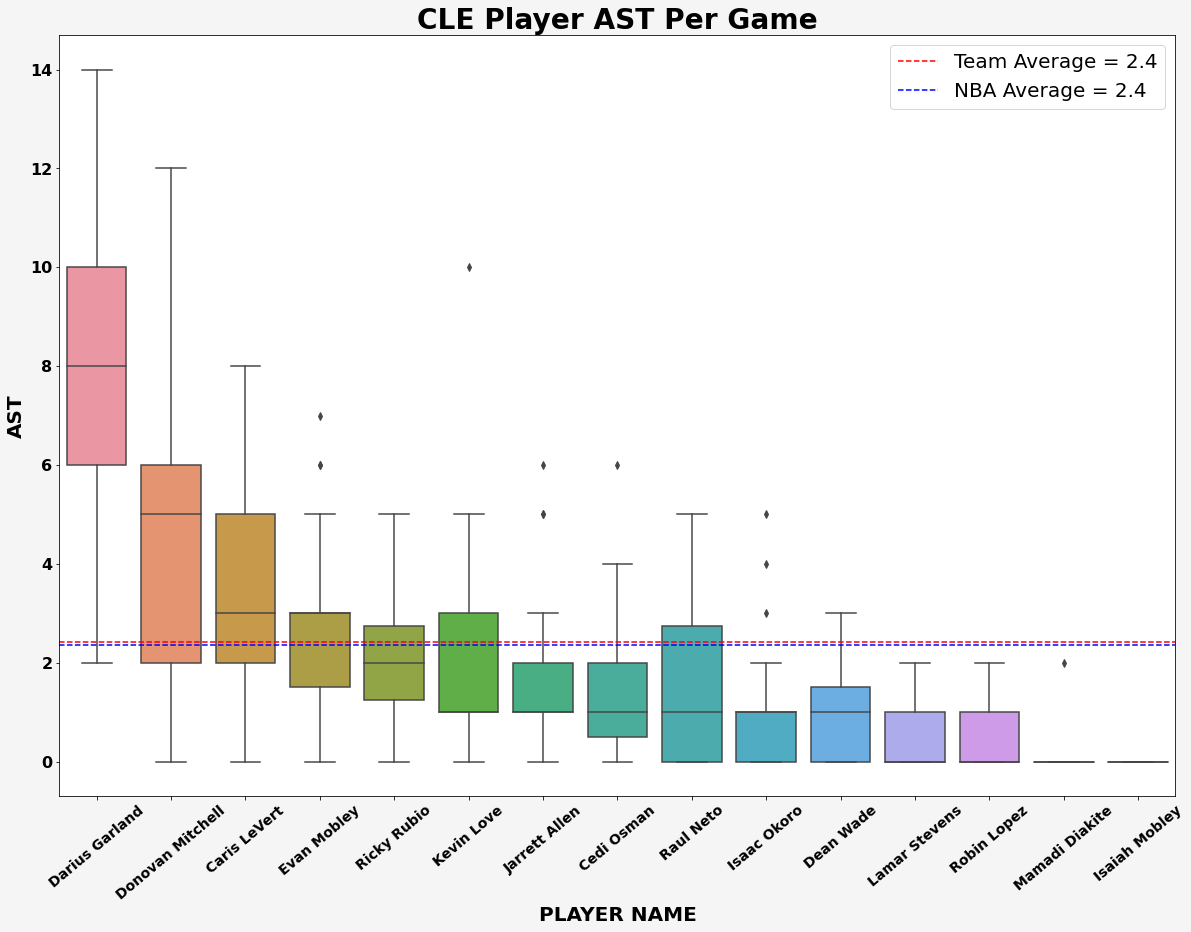

In [41]:
def team_players_stat_whisker(team_abbr, stat):
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_facecolor('whitesmoke')
    plt.rcParams["figure.figsize"] = (20,14)
    df = df_players[df_players.TEAM_ABBREVIATION == team_abbr]
    means_ppg = df.groupby(['PLAYER_NAME'])[stat].mean().sort_values(ascending=[False])
    ax = sns.boxplot(data=df, x='PLAYER_NAME', y=stat, order=means_ppg.index)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    ax.set_xlabel('PLAYER NAME', fontsize=20, fontweight='bold')
    ax.set_ylabel(stat, fontsize=20, fontweight='bold')
    ax.set_title(f'{team_abbr} Player {stat} Per Game', fontsize=28, fontweight='bold')
    
    plt.axhline(y=df[stat].mean(), color='red', linestyle='--', label=f'Team Average = {"{:.1f}".format(df[stat].mean())}')
    plt.axhline(y=df_players[stat].mean(), color='blue', linestyle='--', label=f'NBA Average = {"{:.1f}".format(df_players[stat].mean())}')
    
    plt.legend(loc='best', fontsize=20)
    plt.show()
    
team_players_stat_whisker('CLE', 'AST')

## Function to bar plot for a given stat and team

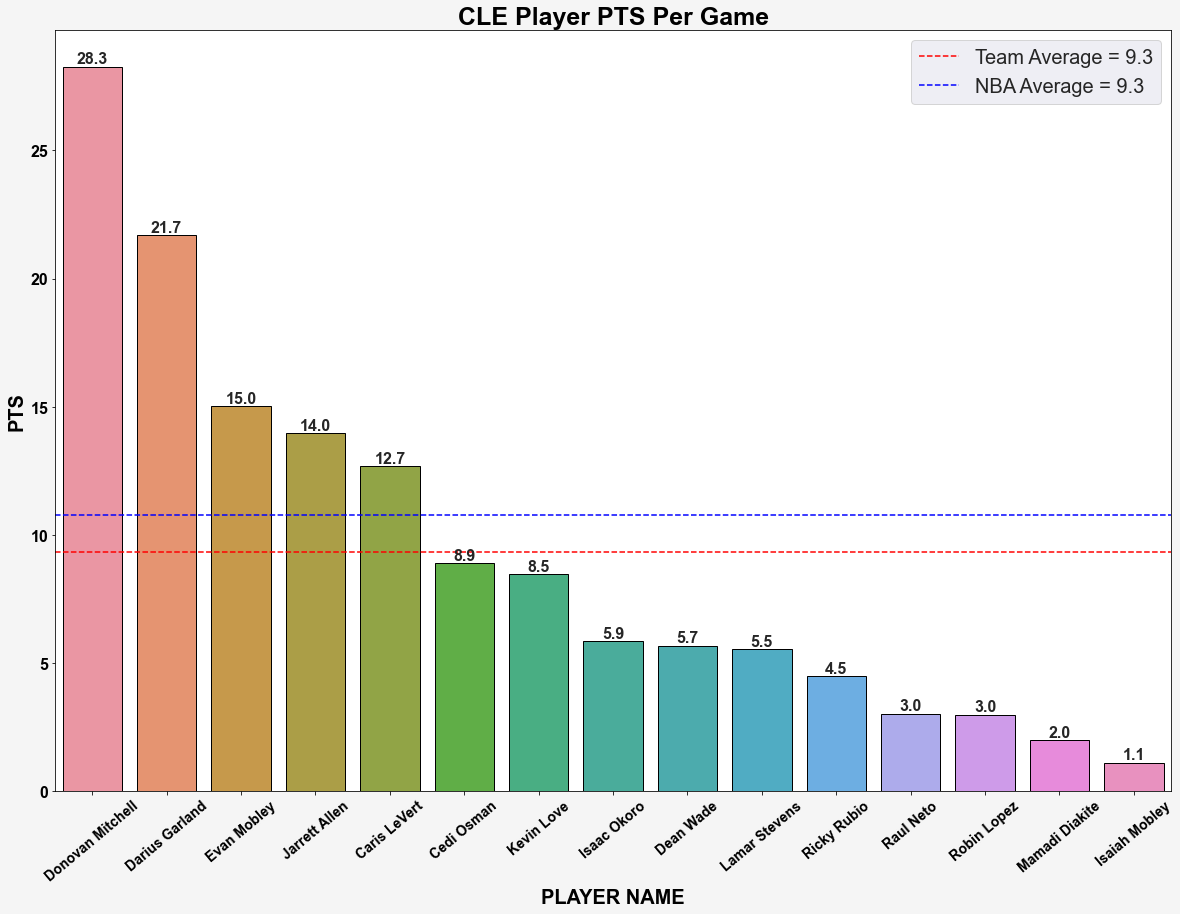

In [42]:
def team_players_stat_bar(team_abbr, stat):
    plt.rcParams["figure.figsize"] = (20,14)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_facecolor('whitesmoke')
    
    sns.set_style("darkgrid")
    #sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgray'})
    
    df_team = team_player_avgs(team_abbr).sort_values(stat,ascending=False).reset_index(drop=True)
    
    ax = sns.barplot(data=df_team, x='PLAYER_NAME', y=stat, edgecolor='black')
    ax.bar_label(ax.containers[0], fontsize=16, fontweight='bold', fmt='%.1f')
    
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, fontsize=14, fontweight='bold')
    plt.yticks(fontsize=16, fontweight='bold')
    
    ax.set_xlabel('PLAYER NAME', fontsize=20, fontweight='bold')
    ax.set_ylabel(stat, fontsize=20, fontweight='bold')
    
    ax.set_title(f'{team_abbr} Player {stat} Per Game', fontsize=25, fontweight='bold')
    
    plt.axhline(y=df_team[stat].mean(), color='red', linestyle='--', label=f'Team Average = {"{:.1f}".format(df_team[stat].mean())}')
    plt.axhline(y=df_players[stat].mean(), color='blue', linestyle='--', label=f'NBA Average = {"{:.1f}".format(df_team[stat].mean())}')
    
    plt.legend(loc='best', fontsize=20)
    
    plt.show()
    
team_players_stat_bar('CLE', 'PTS')

## Player Stat Plot Function

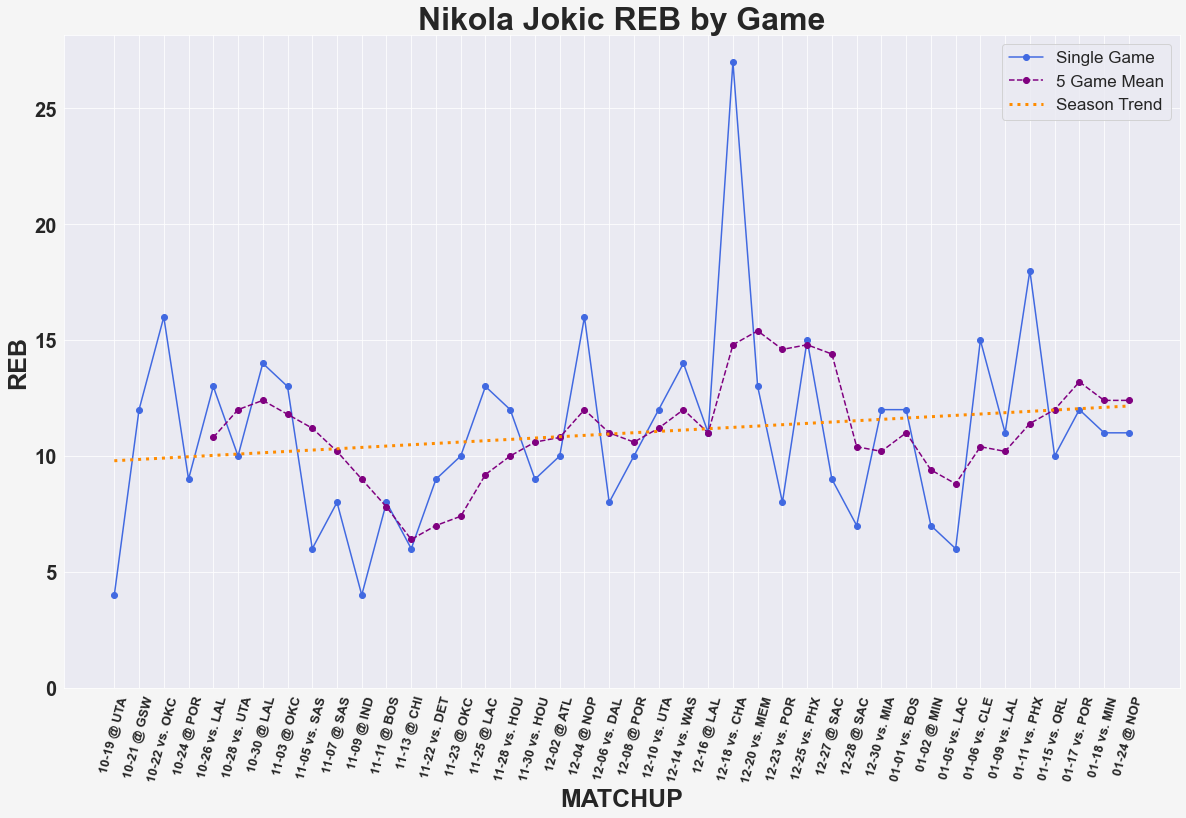

In [43]:
def player_stat_plot(name, stat):
    plt.rcParams["figure.figsize"] = (20,12)
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_facecolor('whitesmoke')
    
    df = player_boxscores_df(name).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    player_stat = plt.plot(df.index, df[stat], marker='o', color='royalblue', label='Single Game')
    if df.GAME_DATE.count()>5:
        rolling_mean_5 = df[stat].rolling(5).mean()
        rolling_mean_5_plot = plt.plot(rolling_mean_5, color="Purple",linestyle='dashed', alpha=1,marker='o', label="5 Game Mean")
    
    if df.GAME_DATE.count()>1:
        z = np.polyfit(df.index, df[stat], 1)
        p = np.poly1d(z)
        season_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=3, color='darkorange', label='Season Trend')
    
    plt.legend(loc='best', fontsize=17)
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, size=13, fontweight='bold')
    if df[stat].max() > 30:
        plt.yticks(list(range(0,df[stat].max()+10,10)),size=16, fontweight='bold')
    elif df[stat].max() <=30:
        plt.yticks(list(range(0,df[stat].max(),5)),size=16, fontweight='bold')
    elif df[stat].max() <=5:
        plt.yticks(list(range(0,df[stat].max()+1,1)),size=16, fontweight='bold')
    plt.ylim(0, None)
    plt.yticks(fontsize=20)
    plt.title(f'{name} {stat} by Game', fontsize=32, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=25, fontweight='bold')
    plt.ylabel(stat, fontsize=25, fontweight='bold')
    plt.show()
    
player_stat_plot('Nikola Jokic', 'REB')

## Function to violin plot a players points, rebounds and assists

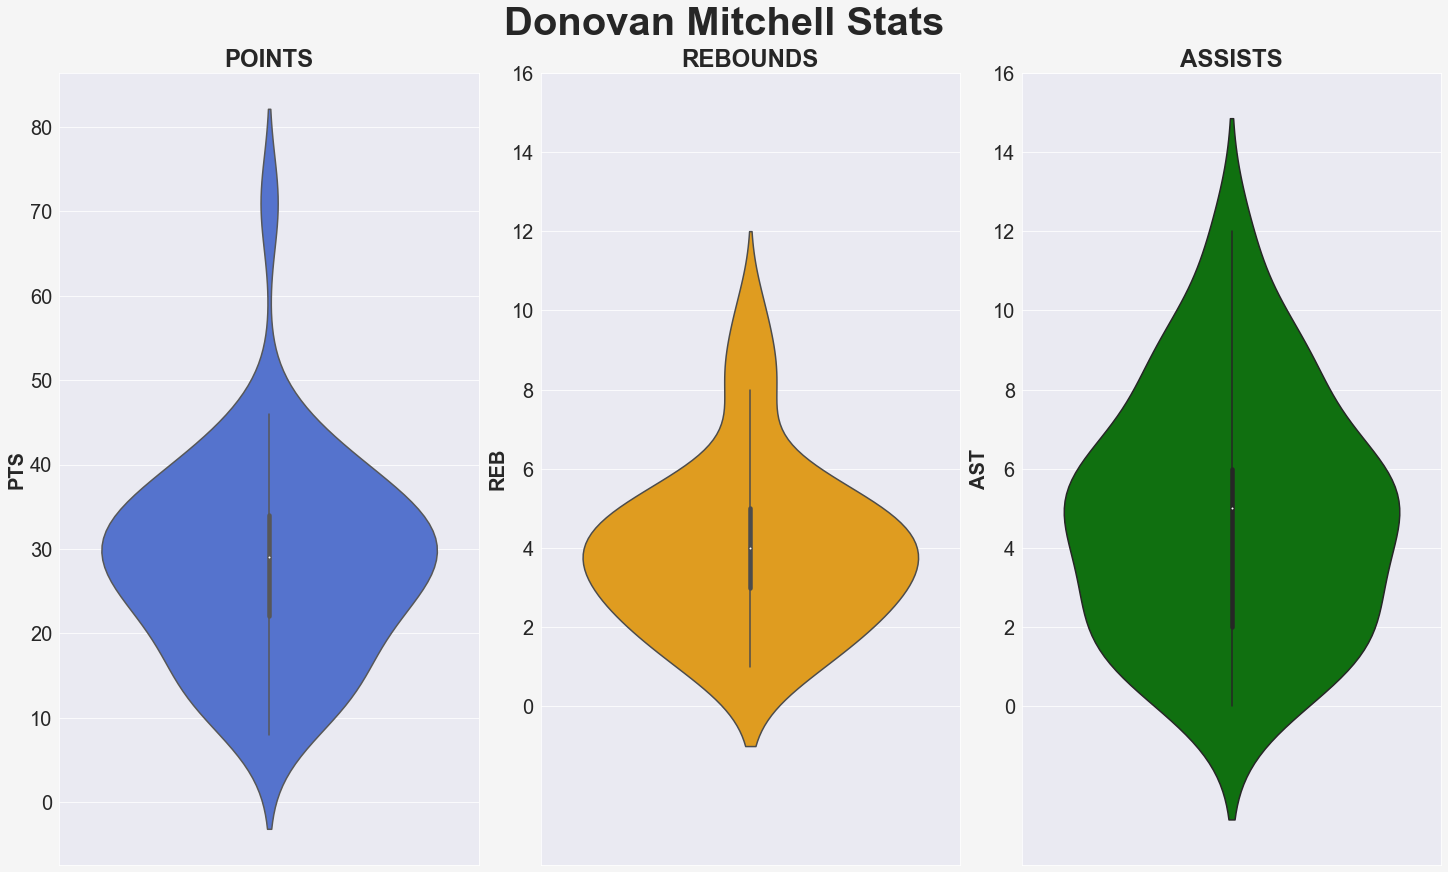

In [44]:
def player_pra_violins(name):
    df = player_boxscores_df(name)
    fig, axs = plt.subplots(nrows=1, ncols=3, sharex='col', constrained_layout=True, sharey=False)
    fig.set_facecolor('whitesmoke')
    
    ax1 = sns.violinplot(data=df, x=df.PLAYER_NAME, y='PTS', ax=axs[0], color='royalblue')
    ax1.set_xlabel('')
    ax1.set_ylabel('PTS',fontsize=20, fontweight='bold')
    ax1.tick_params(bottom=False, labelbottom=False)
    ax1.set_title('POINTS', fontsize=24, fontweight='bold')
    ax1.set_ylim(None, None)
    ax1.tick_params(axis='y', which='major', labelsize=20)
    if df.PTS.max() < 10:
        ax1.set_yticks(list(range(0,df.PTS.max()+5,2)))
    elif df.PTS.max() < 20:
        ax1.set_yticks(list(range(0,df.PTS.max()+10,5)))
    else:
        ax1.set_yticks(list(range(0,df.PTS.max()+10,10)))
    
    ax2 = sns.violinplot(data=df, x=df.PLAYER_NAME, y='REB', ax=axs[1], color='orange')
    ax2.set_xlabel('')
    ax2.set_ylabel('REB',fontsize=20, fontweight='bold')
    ax2.tick_params(bottom=False, labelbottom=False)
    ax2.set_title('REBOUNDS', fontsize=24, fontweight='bold')
    ax2.set_ylim(-4, None)
    ax2.tick_params(axis='y', which='major', labelsize=20)
    
    ax3 = sns.violinplot(data=df, x=df.PLAYER_NAME, y='AST', ax=axs[2], color='green')
    ax3.set_xlabel('')
    ax3.set_ylabel('AST',fontsize=20, fontweight='bold')
    ax3.tick_params(bottom=False, labelbottom=False)
    ax3.set_title('ASSISTS', fontsize=24, fontweight='bold')
    ax3.set_ylim(-4, None)
    ax3.tick_params(axis='y', which='major', labelsize=20)
    
    if df.AST.max()>df.REB.max():
        ax2.set_yticks(list(range(0,df.AST.max()+6,2)))
        ax3.set_yticks(list(range(0,df.AST.max()+6,2)))
    elif df.AST.max()<df.REB.max():
        ax2.set_yticks(list(range(0,df.REB.max()+6,2)))
        ax3.set_yticks(list(range(0,df.REB.max()+6,2)))
    
    fig.suptitle(f'{name} Stats', fontsize=40, fontweight='bold')
    plt.show()
    
player_pra_violins('Donovan Mitchell')

## Function to pie plot a players shot distribution

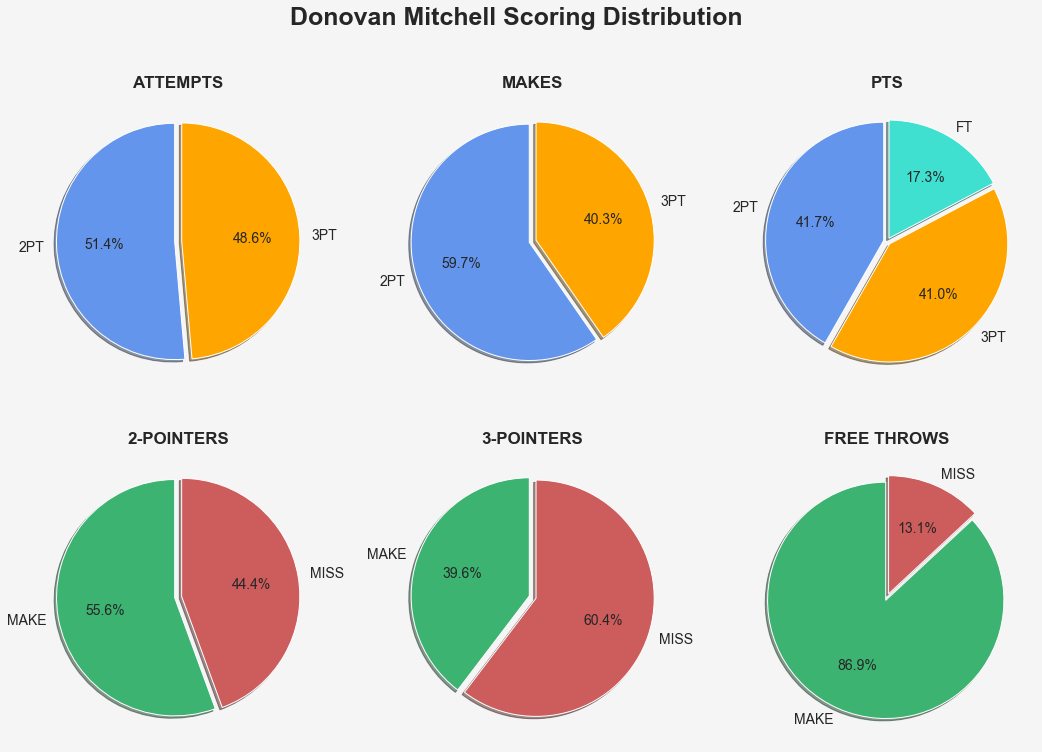

In [45]:
def player_shooter_pies(name):
    try:
        df_player_ind = df_players[df_players.PLAYER_NAME==name]

        data_att = [df_player_ind.FRAC_ATT_2PT.sum(), df_player_ind.FRAC_ATT_3PT.sum()]
        data_mk = [df_player_ind.FRAC_MK_2PT.sum(), df_player_ind.FRAC_MK_3PT.sum()]
        data_pts = [df_player_ind.FRAC_PTS_2PT.sum(), df_player_ind.FRAC_PTS_3PT.sum(), df_player_ind.FRAC_PTS_FT.sum()]

        data_2pt = [df_player_ind.FG2M.sum(), (df_player_ind.FG2A.sum() - df_player_ind.FG2M.sum())]
        data_3pt = [df_player_ind.FG3M.sum(), (df_player_ind.FG3A.sum() - df_player_ind.FG3M.sum())]
        data_ft = [df_player_ind.FTM.sum(), (df_player_ind.FTA.sum() - df_player_ind.FTM.sum())]

        labels1 = ['2PT', '3PT']
        labels2 = ['2PT', '3PT', 'FT']
        labels3 = ['MAKE', 'MISS']
        explode1 = [0.03, 0.03]
        explode2 = [0.03,0.03,0.03]
        colors0 = ['cornflowerblue', 'orange']
        colors1= ['cornflowerblue', 'orange', 'turquoise']
        colors2 = ['mediumseagreen','indianred']

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
        fig.set_facecolor('whitesmoke')
        
        ax[0,0].pie(data_att,
                  labels=labels1,
                  explode=explode1,
                  shadow=True,
                  colors=colors0,
                  autopct='%1.1f%%',
                  textprops={'fontsize': 14},
                  startangle=90)
        ax[0,0].set_title('ATTEMPTS', fontsize=17, fontweight='bold')

        ax[0,1].pie(data_mk,
                  labels=labels1,
                  explode=explode1,
                  shadow=True,
                  colors=colors0,
                  autopct='%1.1f%%',
                  textprops={'fontsize': 14},
                  startangle=90)
        ax[0,1].set_title('MAKES', fontsize=17, fontweight='bold')

        ax[0,2].pie(data_pts,
                  labels=labels2,
                  explode=explode2,
                  shadow=True,
                  colors=colors1,
                  autopct='%1.1f%%',
                  textprops={'fontsize': 14},
                  startangle=90)
        ax[0,2].set_title('PTS', fontsize=17, fontweight='bold')
        
        if data_2pt[0]!=0:
            ax[1,0].pie(data_2pt,
                      labels=labels3,
                      explode=explode1,
                      colors=colors2,
                      shadow=True,
                      autopct='%1.1f%%',
                      textprops={'fontsize': 14},
                      startangle=90)
            ax[1,0].set_title('2-POINTERS', fontsize=17, fontweight='bold')
        
        if data_3pt[0]!=0:
            ax[1,1].pie(data_3pt,
                      labels=labels3,
                      explode=explode1,
                      colors=colors2,
                      shadow=True,
                      autopct='%1.1f%%',
                      textprops={'fontsize': 14},
                      startangle=90)
            ax[1,1].set_title('3-POINTERS', fontsize=17, fontweight='bold')

        if data_ft[0]!=0:
            ax[1,2].pie(data_ft,
                      labels=labels3,
                      explode=explode1,
                      colors=colors2,
                      shadow=True,
                      autopct='%1.1f%%',
                      textprops={'fontsize': 14},
                      startangle=90)
            ax[1,2].set_title('FREE THROWS', fontsize=17, fontweight='bold')

        fig.suptitle(f'{name} Scoring Distribution', fontsize=25, fontweight="bold")
        plt.show()
    except: pass
        
player_shooter_pies('Donovan Mitchell')

## Function to webscrape and save a teams logo

In [46]:
def get_team_logo(team_name):
    team_name_formatted = team_name.lower()
    team_name_formatted = team_name_formatted.replace(' ','-')
    logo_url = urllib.request.urlretrieve(f'https://cdn.freebiesupply.com/images/large/2x/{team_name_formatted}-logo-transparent.png')
    logo_pic = plt.imread(logo_url[0])
    plt.imshow(logo_pic)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f'C:\\Users\\Peter\\NBA_Logos\\{team_name_formatted}.png', pad_inches=0, bbox_inches = 'tight')
    plt.clf()
    
    if team_name == 'Phoenix Suns':
        team_name_formatted = team_name.lower()
        team_name_formatted = team_name_formatted.replace(' ','-')
        logo_url = urllib.request.urlretrieve('https://images.vexels.com/media/users/3/131727/isolated/preview/603218e104d110c73cf33fa5814389ac-phoenix-suns-logo-by-vexels.png')
        logo_pic = plt.imread(logo_url[0])
        plt.imshow(logo_pic)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(f'C:\\Users\\Peter\\NBA_Logos\\{team_name_formatted}.png', pad_inches=0, bbox_inches = 'tight')
        plt.clf()
        

lebron_team_id = df_players[df_players.PLAYER_NAME=='LeBron James'].TEAM_ID.unique().item()
lebron_team_name = str(df_players[df_players.PLAYER_NAME=='LeBron James'].TEAM_NAME.unique().item())
lebron_id = df_players[df_players.PLAYER_NAME=='LeBron James'].PLAYER_ID.unique().item()

#for i in df.TEAM_NAME.unique():
#    print(i)
#    try: get_team_logo(i)
#    except: print('Couldnt Find')

## Function to webscrape and return a players summary

In [47]:
def career_summary(name):
    player_id = int(df_players[df_players.PLAYER_NAME == name].PLAYER_ID.unique().item(0))
    formatted_name = str(name).replace(' ','-').lower()
    html = requests.get(f'https://www.nba.com/player/{str(player_id)}/{formatted_name}/bio').content
    soup = BeautifulSoup(html, 'html.parser')
    divs = str(soup.find_all("div", {"class": "cplayer-bio__content"})[0].text).replace('\r\n', ' ')
    #div1 = str(div1).split('<h3>')[0]
    print(color.BOLD + 'Professional Summary' + color.END)
    try:
        divs = divs.split("PROFESSIONAL CAREER: ")[1]
        try:
            divs = divs.split("2019-20 SEASON:")[0]
        except: pass
    except: pass
    print(divs)

career_summary('Andre Iguodala')

Professional Summary
Has appeared in 1129 games (779 starts) during his 16-year NBA career and has averaged 12.0 points, 5.1 rebounds, 4.3 assists, 1.49 steals and 33.2 minutes while shooting 46.5 percent from the floor, 33.3 percent from three-point range and 70.9 percent from the foul line…has missed 88 games due to injury/illness, 18 for rest-related purposes, 51 on the inactive list while awaiting a trade and another resulting from a pending trade…missed one game as a DNP-CD…has been crowned NBA Finals MVP once…is a one-time NBA All-Star…two-time participant in the NBA Rookie Challenge, taking home MVP honors once…has been named to the NBA All-Defensive First Team and NBA All-Defensive Second Team once each…was an NBA All-Rookie First Team selection…has scored in double figures on 655 occasions with 197 games of at least 20 points and 15 games with at least 30 points…his longest streak of consecutive double-figure scoring games is 63 (Dec. 1, 2007-Apr. 9, 2008)…has grabbed double-f

## Webscrape All Star Roster Data

In [48]:
'''
tables = pd.read_html("https://en.wikipedia.org/wiki/List_of_NBA_All-Stars")
df_all_stars = tables[1]
df_all_stars.Player = df_all_stars.Player.map(lambda x: x.strip('§*^'))
df_all_stars = df_all_stars.drop(columns=['Reference','Notes'], axis=1)
df_all_stars = df_all_stars.rename(columns={'Selections[c]':'Selections'})
df_all_stars = df_all_stars.rename(columns={'#':'Apps'})
df_all_stars.Selections = df_all_stars.Selections.str.replace('–','-')
df_all_stars.Player = df_all_stars.Player.str.replace('–','-')
df_all_stars['Years'] = ''
df_all_stars.loc[df_all_stars['Player'] == 'Nikola Jokić', 'Player'] = 'Nikola Jokic'
df_all_stars.loc[df_all_stars['Player'] == 'Luka Dončić', 'Player'] = 'Luka Doncic'
df_all_stars.to_csv('NBA_allstars.csv')
'''

# Update after 2023 all star game

df_all_stars = pd.read_csv('NBA_allstars.csv')
df_all_stars

,Unnamed: 0,Player,Apps,Selections,Years
0,0,Kareem Abdul-Jabbar*[a],19,1970-1977; 1979-1989,NaN
1,1,Kobe Bryant,18,1998; 2000-2016,NaN
2,2,LeBron James,18,2005-2022,NaN
3,3,Tim Duncan,15,1998; 2000-2011; 2013; 2015,NaN
4,4,Kevin Garnett,15,1997-1998; 2000-2011; 2013,NaN
...,...,...,...,...,...
439,439,Mo Williams,1,2009,NaN
440,440,Zion Williamson,1,2021,NaN
441,441,Kevin Willis,1,1992,NaN
442,442,Metta World Peace[d],1,2004,NaN


In [49]:
def convert_selections(a):
    data_yrs = []
    a = str(a)
    a = a.replace(" ","")
    if ';' in a:
        ranges = a.split(';')
        for i in ranges:
            if '-' in i:
                i_min = int(i.split('-')[0])
                i_max = int(i.split('-')[1])
                for j in range(i_min,i_max+1):
                    data_yrs.append(int(j))
            else:
                data_yrs.append(int(i))
    elif '-' in a:
        a_min = int(a.split('-')[0])
        a_max = int(a.split('-')[1])
        for k in range(a_min,a_max+1):
            data_yrs.append(int(k))
    else:
        a_int = int(a)
        data_yrs.append(a_int)
    return data_yrs


In [50]:
df_all_stars.Years = df_all_stars.Selections
df_all_stars.Years = df_all_stars.Years.map(lambda x: convert_selections(x))
df_all_stars_yearly = df_all_stars.copy()
df_all_stars_yearly = df_all_stars_yearly.drop(columns=['Selections'], axis=1)
df_all_stars_yearly

,Unnamed: 0,Player,Apps,Years
0,0,Kareem Abdul-Jabbar*[a],19,"[1970, 1971, 1972, 1973, 1974, 1975, 1976, 197..."
1,1,Kobe Bryant,18,"[1998, 2000, 2001, 2002, 2003, 2004, 2005, 200..."
2,2,LeBron James,18,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
3,3,Tim Duncan,15,"[1998, 2000, 2001, 2002, 2003, 2004, 2005, 200..."
4,4,Kevin Garnett,15,"[1997, 1998, 2000, 2001, 2002, 2003, 2004, 200..."
...,...,...,...,...
439,439,Mo Williams,1,[2009]
440,440,Zion Williamson,1,[2021]
441,441,Kevin Willis,1,[1992]
442,442,Metta World Peace[d],1,[2004]


## Webscrape Finals Winners and Rosters

In [51]:

pd.set_option('display.float_format', '{:.10g}'.format)

tables = pd.read_html("https://basketball.fandom.com/wiki/List_of_NBA_champions")
df_finals_teams = tables[0]

df_finals_teams = df_finals_teams.drop(df_finals_teams.columns[[i for i in range(9,27)]], axis=1)
df_finals_teams = df_finals_teams.drop(df_finals_teams.columns[[1,3,6,8]], axis=1)

header_row = df_finals_teams.iloc[3]
df_finals_teams = pd.DataFrame(df_finals_teams.values[4:], columns=header_row).reset_index(drop=True)

df_finals_teams['Champ_abbr'] = df_finals_teams.Champions
df_finals_teams['Champ_abbr'] = df_finals_teams['Champ_abbr'].map(team_name_abbr_dict)

df_finals_teams['Champ_ID'] = df_finals_teams.Champions
df_finals_teams['Champ_ID'] = df_finals_teams['Champ_ID'].map(team_id_dict)


df_finals_teams_post2000 = df_finals_teams[::-1].head(23).reset_index(drop=True)
df_finals_teams_post2000

3,Season,Champions,Series,Losing Team,Most Valuable Player,Champ_abbr,Champ_ID
0,2022,Golden State Warriors,4–2,Boston Celtics,Stephen Curry,GSW,1610612744
1,2021,Milwaukee Bucks,4–2,Phoenix Suns,Giannis Antetokounmpo,MIL,1610612749
2,2020,Los Angeles Lakers,4–2,Miami Heat,LeBron James,LAL,1610612747
3,2019,Toronto Raptors,4–2,Golden State Warriors,Kawhi Leonard,TOR,1610612761
4,2018,Golden State Warriors,4–0,Cleveland Cavaliers,Kevin Durant,GSW,1610612744
5,2017,Golden State Warriors,4–1,Cleveland Cavaliers,Kevin Durant,GSW,1610612744
6,2016,Cleveland Cavaliers,4–3,Golden State Warriors,LeBron James,CLE,1610612739
7,2015,Golden State Warriors,4–2,Cleveland Cavaliers,Andre Iguodala,GSW,1610612744
8,2014,San Antonio Spurs,4–1,Miami Heat,Kawhi Leonard,SAS,1610612759
9,2013,Miami Heat,4–3,San Antonio Spurs,LeBron James,MIA,1610612748


In [52]:
'''
df_finals_champs_roster_post2000 = pd.DataFrame()

team_num_dict = {'BOS':'2', 'GSW':'9', 'CLE':'5', 'MIL':'16', 'LAL':'13', 'TOR':'28', 'SAS':'26', 'MIA':'15', 'DAL':'6', 'DET':'8'}

for i in df_finals_teams_post2000.Season:
    df_champs_roster = pd.DataFrame()
    champs = df_finals_teams_post2000[df_finals_teams_post2000.Season ==i].Champions.item()
    champs_formatted = champs.replace(" ","-")
    champs_abbr = str(df_finals_teams_post2000[df_finals_teams_post2000.Season ==i].Champ_abbr.item())
    season = str(i)
    team_num = team_num_dict[champs_abbr]
    
    tables = pd.read_html(f'https://basketball.realgm.com/nba/teams/{champs_formatted}/{team_num}/Rosters/Playoff/{season}')
    df_champs_roster = tables[12]
    
    df_champs_roster['Champs'] = champs
    df_champs_roster['Champs_abbr'] = champs_abbr
    df_champs_roster['Season'] = season
    df_finals_champs_roster_post2000 = pd.concat([df_finals_champs_roster_post2000, df_champs_roster])
    
df_finals_champs_roster_post2000 = df_finals_champs_roster_post2000.reset_index(drop=True)

df_finals_champs_roster_post2000 = df_finals_champs_roster_post2000.copy()
df_finals_champs_roster_post2000.to_csv('df_finals_champs_roster_post2000.csv', index=False)
'''

# UPDATE AFTER 2023 FINALS !!!

df_finals_champs_roster_post2000 = pd.read_csv('df_finals_champs_roster_post2000.csv')
df_finals_champs_roster_post2000

,Player,Pos,HT,WT,Birth Date,Age,Pre-Draft Team,YOS,Draft Status,Champs,Champs_abbr,Season
0,Juan Toscano-Anderson,SF,6-6,213,"Apr 10, 1993",29,Marquette,2,"2015 NBA Draft, Undrafted",Golden State Warriors,GSW,2022
1,Nemanja Bjelica,PF,6-10,235,"May 9, 1988",33,KK Crvena Zvezda (Serbia),6,"2010 2nd Rnd, #35, Washington Wizards",Golden State Warriors,GSW,2022
2,Stephen Curry,PG,6-3,198,"Mar 14, 1988",34,Davidson,12,"2009 1st Rnd, #7, Golden State Warriors",Golden State Warriors,GSW,2022
3,Draymond Green,PF,6-6,234,"Mar 4, 1990",32,Michigan State,9,"2012 2nd Rnd, #35, Golden State Warriors",Golden State Warriors,GSW,2022
4,Andre Iguodala,SF/SG,6-6,215,"Jan 28, 1984",38,Arizona,17,"2004 1st Rnd, #9, Philadelphia Sixers",Golden State Warriors,GSW,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
335,Tyronn Lue,PG,6-0,170,"May 3, 1977",22,Nebraska,1,"1998 1st Rnd, #23, Denver Nuggets",Los Angeles Lakers,LAL,2000
336,Shaquille O'Neal,C,7-1,325,"Mar 6, 1972",28,LSU,7,"1992 1st Rnd, #1, Orlando Magic",Los Angeles Lakers,LAL,2000
337,Glen Rice,PF,6-8,228,"May 28, 1967",32,Michigan,10,"1989 1st Rnd, #4, Miami Heat",Los Angeles Lakers,LAL,2000
338,John Salley,C,6-11,230,"May 16, 1964",35,Georgia Tech,10,"1986 1st Rnd, #11, Detroit Pistons",Los Angeles Lakers,LAL,2000


## Player Regression Analysis for all performances

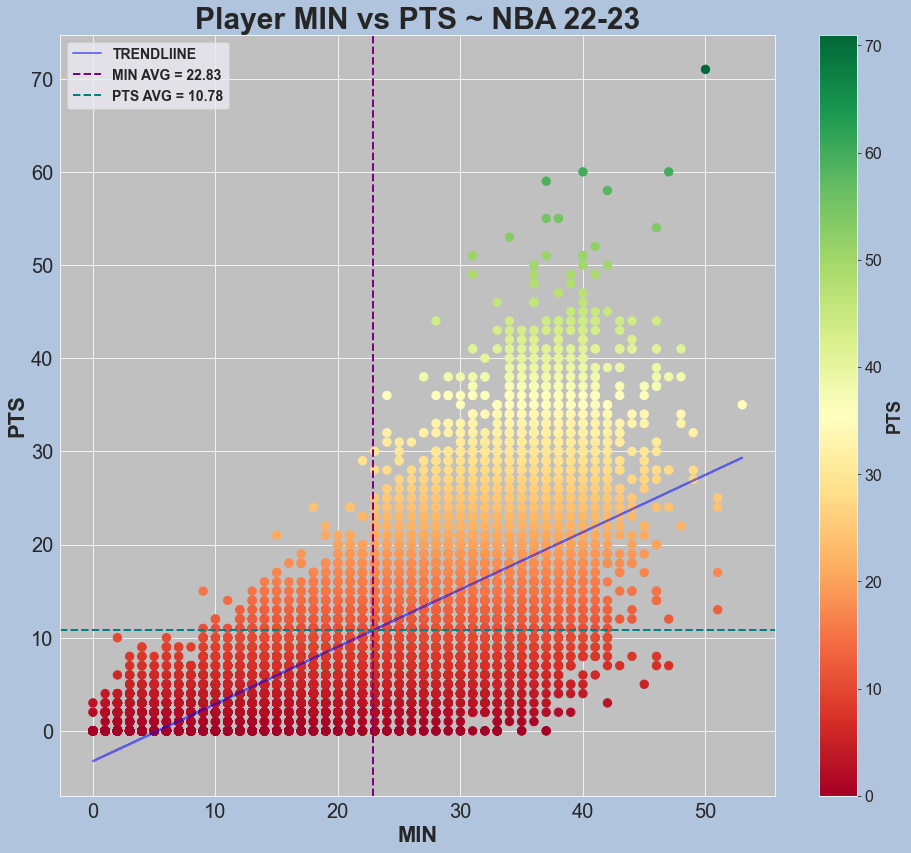


Season Trend Line Equation: y = 0.614707x + (-3.255628)

R-squared: 0.5503134382491588

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.890e+04
Date:                Thu, 26 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:35:07   Log-Likelihood:                -49752.
No. Observations:               15450   AIC:                         9.951e+04
Df Residuals:                   15448   BIC:                         9.952e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [53]:
# Possibly rename function in future?

def player_stat_reg_analysis_all_perf(statx, staty):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))

    x=df_players[statx]
    y=df_players[staty]

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)

    # TODO: Make custom colormap option
    plt.scatter(x,y, c=y, cmap='RdYlGn', s=70)

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(x.mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(y.mean(),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=22, fontweight='bold')
    plt.ylabel(staty, fontsize=22, fontweight='bold')
    
    plt.legend(loc='best', prop={'weight':'bold', 'size':14})

    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    plt.title(f'Player {statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')
    
    cbar = plt.colorbar()

    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if np.max(x)<=15 and np.max(x)>1.0:
        plt.xticks([i for i in range(0, np.max(x)+1)])
        
    if np.max(y)<=15 and np.max(y)>1.0:
        plt.yticks([i for i in range(0, np.max(y)+1)])

    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()
    
    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_players).fit()
    print(lm.summary())
    
    # TODO: ADD OPTION TO SAVE OUTPUT
    
player_stat_reg_analysis_all_perf('MIN', 'PTS')

## Player Salary vs Stats Avg Regression Analysis Function

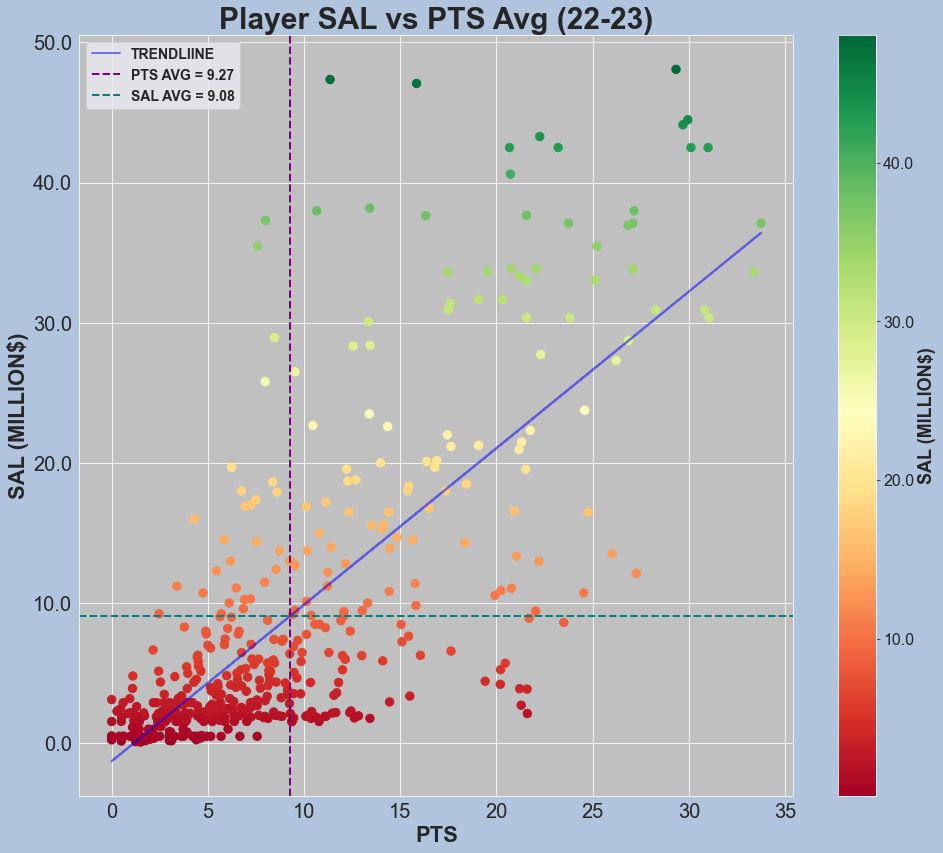


Season Trend Line Equation: y = 1116323.698283x + (-1268710.860964)

R-squared: 0.5479540418975783



In [54]:
def player_reg_analysis_sal_avg(statx):
    
    def millions_formatter(x, pos):
        return x / 1000000
        #return f'{x / 1000000}'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    
    x=df_avg_sal_stripped[statx]
    y=df_avg_sal_stripped['SAL_2022/23']

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)

    # TODO: Make custom colormap option
    plt.scatter(x,y, c=y, cmap='RdYlGn', s=70)

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(x.mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"SAL AVG = {round(millions_formatter(y.mean(),1),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=22, fontweight='bold')
    plt.ylabel('SAL (MILLION$)', fontsize=22, fontweight='bold')
    
    plt.legend(loc='best', prop={'weight':'bold', 'size':14})

    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    plt.title(f'Player SAL vs {statx} Avg (22-23)', fontsize=30, fontweight='bold')
    
    if np.max(x)<=15 and np.max(x)>1.0:
        plt.xticks([i for i in range(0, np.max(x)+1)])
        
    if np.max(y)<=15 and np.max(y)>1.0:
        plt.yticks([i for i in range(0, np.max(y)+1)])
        
    plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
    
    ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 8))
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label='SAL (MILLION$)', size=18, weight='bold')

    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))
    
    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()
    
    
    # TODO: ADD OPTION TO SAVE OUTPUT
    
player_reg_analysis_sal_avg('PTS')

## 3D Scatter Plot Function

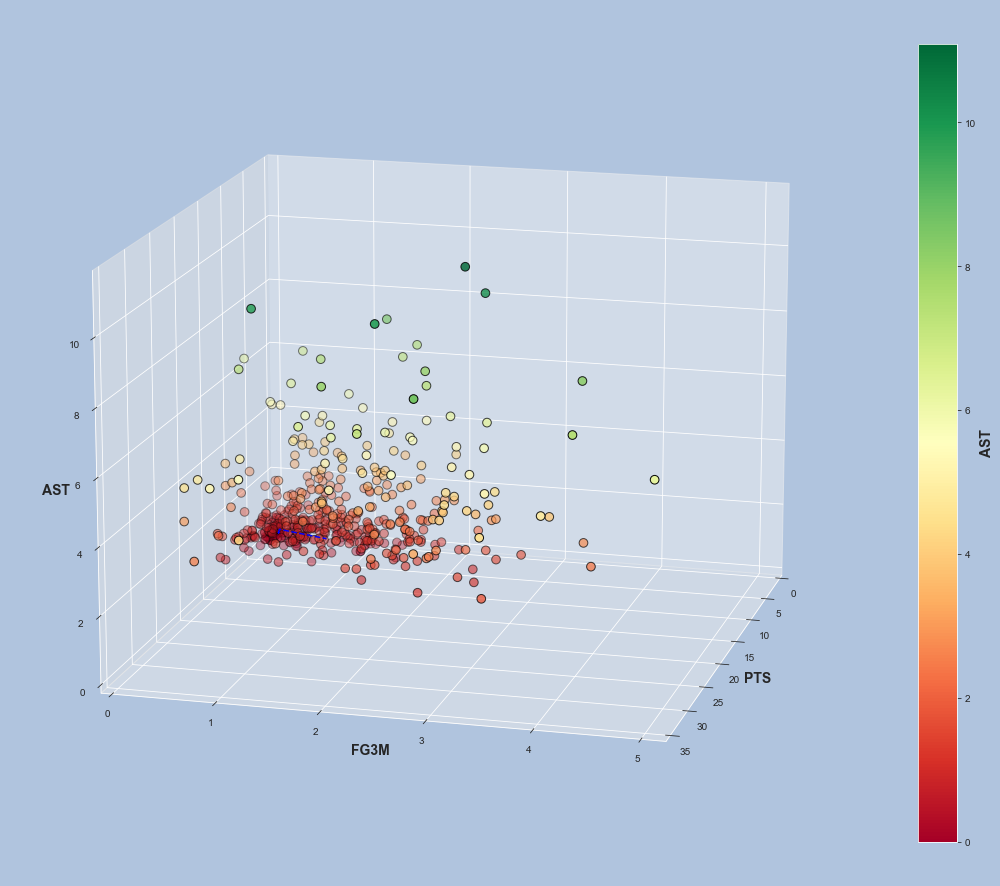

In [55]:
def scatter_3d(df,x,y,z, xview=15, yview=15,zview=0, sv_anim=False):
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()
    
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(projection='3d')
    
    ax.set_facecolor('lightsteelblue')
    fig.set_facecolor('lightsteelblue')
    
    ax.set_xlabel(x, fontweight='bold', fontsize=14)
    ax.set_ylabel(y, fontweight='bold', fontsize=14)
    ax.set_zlabel(z, fontweight='bold', fontsize=14)
    
    xdata=df[x].fillna(0)
    ydata=df[y].fillna(0)
    zdata=df[z].fillna(0)
    
    sc = ax.scatter(xdata,ydata,zdata,c=zdata, cmap=initial_cmap, edgecolor='black', s=75)

    cbar = fig.colorbar(sc, ax=ax, fraction=0.042, pad=0.04)
    cbar.set_label(z, fontsize=14, fontweight='bold')
    
    t = np.arange(df.shape[0])

    fitx = np.polyfit(t, xdata, 10)
    fity = np.polyfit(t, ydata, 10)
    fitz = np.polyfit(t, zdata, 10)

    ax.plot(fitx,fity,fitz, color='blue', linestyle='dashed')
    
    plt.xlim(0,None)
    plt.ylim(0,None)
    ax.set_zlim(0,None)
    
    plt.grid()
    plt.tight_layout()
    
    ax.view_init(xview,yview,zview)
        
    if sv_anim:
        
        def init():
            ax.view_init(elev=15., azim=0)
            return [sc]
        
        def animate(i):
            ax.view_init(elev=15., azim=i)
            return [sc]
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
        
        plt.show()
        
        try: os.mkdir('C:\\Users\\Peter\\NFL_3D_Scatter_Anims')
        except: pass
        
        try: ani.save(f'C:\\Users\\Peter\\NFL_3D_Scatter_Anims\\{x}_{y}_{z}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        except: pass
        
    
    else:
        plt.show()
        
scatter_3d(df_player_avg,'PTS','FG3M','AST', sv_anim=False)

# Go to save location to view animation
# TODO: Display animation, currently having issues, but saved video is available

## Function to return a player's image, edited with relevant info

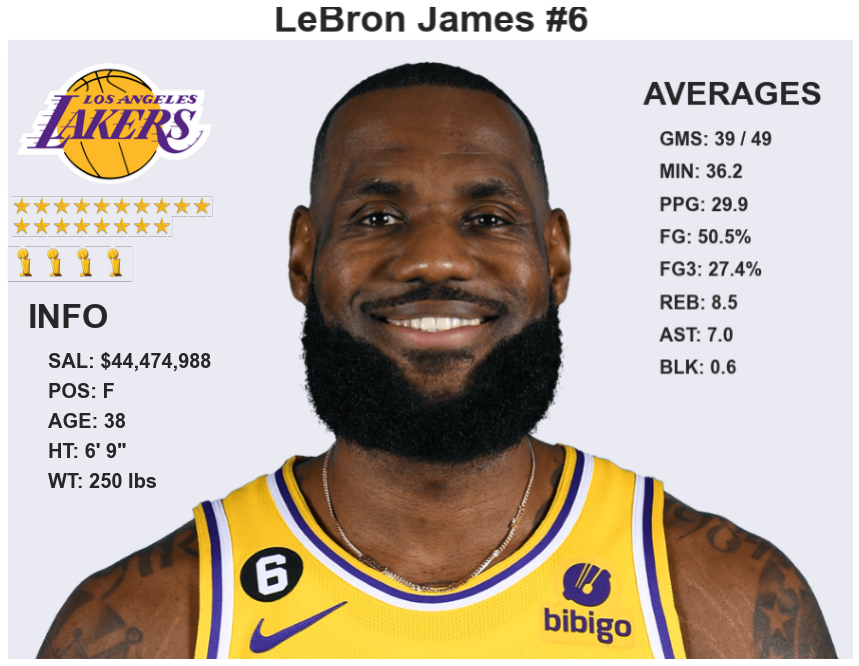

In [56]:
def display_player_image(player_id):
    
    team_index = len(df_players[df_players.PLAYER_ID==lebron_id].TEAM_NAME.unique()) - 1
    
    team_name = str(df_players[df_players.PLAYER_ID==player_id].TEAM_NAME.unique().item(team_index))
    team_name_formatted = team_name.lower()
    team_name_formatted = team_name_formatted.replace(' ','-')
    
    player_name = df_players[df_players.PLAYER_ID == player_id].PLAYER_NAME.unique().item()
    player_name_formatted = player_name.replace(' ','_')
    
    pic = urllib.request.urlretrieve(f"https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png")
    player_pic = plt.imread(pic[0])
    ax1 = plt.imshow(player_pic)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.text(780, 80, 'AVERAGES', fontsize=34, fontweight='bold')
    
    games_num = len(df_players[df_players.PLAYER_ID==player_id].GAME_DATE.unique())
    games_team_num = len(df_players[df_players.TEAM_NAME==team_name].GAME_DATE.unique())
    plt.text(800, 130, f'GMS: {games_num} / {games_team_num}', fontsize=20, fontweight='bold')
    
    minutes = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].MIN.mean())
    plt.text(800, 170, f'MIN: {minutes}', fontsize=20, fontweight='bold')
    
    ppg = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].PTS.mean())
    plt.text(800, 210, f'PPG: {ppg}', fontsize=20, fontweight='bold')
    
    fg_per = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].FG_PCT.mean()*100)
    plt.text(800, 250, f'FG: {fg_per}%', fontsize=20, fontweight='bold')
    
    fg3_per = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].FG3_PCT.mean()*100)
    plt.text(800, 290, f'FG3: {fg3_per}%', fontsize=20, fontweight='bold')
    
    reb = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].REB.mean())
    plt.text(800, 330, f'REB: {reb}', fontsize=20, fontweight='bold')
    
    ast = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].AST.mean())
    plt.text(800, 370, f'AST: {ast}', fontsize=20, fontweight='bold')
    
    blk = "{:.1f}".format(df_players[df_players.PLAYER_ID==player_id].BLK.mean())
    plt.text(800, 410, f'BLK: {blk}', fontsize=20, fontweight='bold')

    
    #plt.text(770, 250, 'Pros', fontsize=34, fontweight='bold')
    
    
    logo_image = Image.open(f'C:\\Users\\Peter\\NBA_Logos\\{team_name_formatted}.png')
    baseheight = 150
    hpercent = (baseheight / float(logo_image.size[1]))
    wsize = int((float(logo_image.size[0]) * float(hpercent)))
    logo_image = logo_image.resize((wsize, baseheight), Image.Resampling.LANCZOS)
    
    try:
        num = int(df_player_bios[df_player_bios.Name == player_name].Jersey)
        title = f'{player_name} #{num}'
    except:
        title=f'{player_name}'
        
    plt.title(title, fontsize=40, fontweight='bold')
    plt.savefig(f'C:\\Users\\Peter\\NBA_Player_Summaries\\{player_name_formatted}.png',  pad_inches=0, bbox_inches = 'tight')
    plt.clf()
    
    player_image = Image.open(f'C:\\Users\\Peter\\NBA_Player_Summaries\\{player_name_formatted}.png')
    
    width1, height1 = player_image.size
    width2, height2 = logo_image.size
    player_image.paste(logo_image, (0, height2-100))
    
    plt.imshow(player_image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig(f'C:\\Users\\Peter\\NBA_Player_Summaries\\{player_name_formatted}.png',  pad_inches=0, bbox_inches = 'tight')
    plt.clf()
    
    player_image = Image.open(f'C:\\Users\\Peter\\NBA_Player_Summaries\\{player_name_formatted}.png')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    star_image = Image.open('C:\\Users\\Peter\\star.png')
    baseheight_star = 20
    hpercent_star = (baseheight_star / float(star_image.size[1]))
    wsize_star = int((float(star_image.size[0]) * float(hpercent_star)))
    star_image = star_image.resize((wsize_star, baseheight_star), Image.Resampling.LANCZOS)
    
    logos_bottom_height=height2+80
    
    all_star=False
    all_star_10=False
    
    for i in df_all_stars.Player:
        if player_name == i:
            all_star=True
            for i in range(int(df_all_stars[df_all_stars.Player == player_name].Apps.item())):
                if i<=9: 
                    logos_bottom_height=height2+110
                    player_image.paste(star_image, (5+i*20, height2+40))
                elif i>9:
                    all_star_10=True
                    logos_bottom_height = height2+130
                    player_image.paste(star_image, (5+(i-10)*20, height2+60))
                    
    trophy_image = Image.open('C:\\Users\\Peter\\finals_trophy.png')
    baseheight_trophy = 35
    hpercent_trophy = (baseheight_trophy / float(trophy_image.size[1]))
    wsize_trophy = int((float(trophy_image.size[0]) * float(hpercent_trophy)))
    trophy_image = trophy_image.resize((wsize_trophy, baseheight_trophy), Image.Resampling.LANCZOS)
    
    #df_finals_champs_roster_post2000[df_finals_champs_roster_post2000.Player=='LeBron James'].Season.count()
    
    for i in df_finals_champs_roster_post2000.Player:
        if player_name == i:
            for i in range(int(df_finals_champs_roster_post2000[df_finals_champs_roster_post2000.Player == player_name].Season.count())):
                if all_star_10 == True:
                    player_image.paste(trophy_image, (i*30, height2+90))
                    logos_bottom_height= height2+170
                elif all_star == True:
                    player_image.paste(trophy_image, (i*30, height2+70))
                    logos_bottom_height= height2+150
                else:
                    player_image.paste(trophy_image, (i*30, height2+50))
                    logos_bottom_height= height2+130
    
    plt.text(20, logos_bottom_height, 'INFO', fontsize=34, fontweight='bold')
    
    try:
        sal = df_salaries[df_salaries.Player == player_name]['2022/23'].item()
        plt.text(40, logos_bottom_height+40, f'SAL: {sal}', fontsize=20, fontweight='bold')
    except: pass
    
    try:    
        pos = df_player_bios[df_player_bios.Name == player_name].POS.item()
        plt.text(40, logos_bottom_height+70, f'POS: {pos}', fontsize=20, fontweight='bold')
    except: pass
    
    try:
        age = df_player_bios2[df_player_bios2.Name == player_name].Age.item()
        plt.text(40, logos_bottom_height+100, f'AGE: {age}', fontsize=20, fontweight='bold')
    except: pass
    
    try:
        ht = df_player_bios2[df_player_bios2.Name == player_name].HT.item()
        wt = df_player_bios2[df_player_bios2.Name == player_name].WT.item()
        
        plt.text(40, logos_bottom_height+130, f'HT: {ht}', fontsize=20, fontweight='bold')
        plt.text(40, logos_bottom_height+160, f'WT: {wt}', fontsize=20, fontweight='bold')
    except: pass
    
    plt.imshow(player_image)
    
    plt.savefig(f'C:\\Users\\Peter\\NBA_Player_Summaries\\{player_name_formatted}.png',  pad_inches=0, bbox_inches = 'tight')
    plt.show()
    
display_player_image(lebron_id)

## Function to bar plot stat average leaders

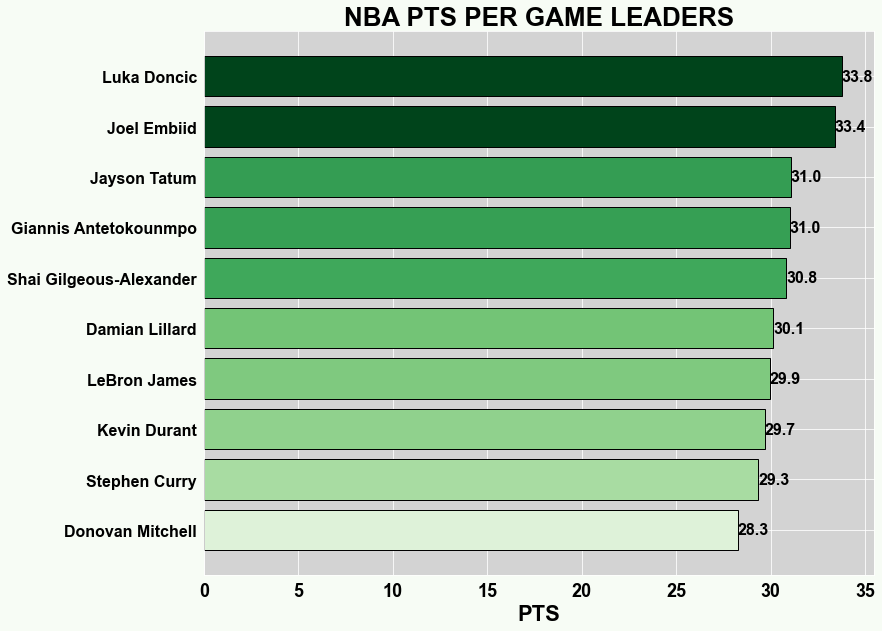

In [57]:
def player_avg_leaders(stat, pal, num=10):
    
    if num<=10: figheight=num
    if num>10 and num>=20: figheight=num*0.9
    if num>20 and num>=30: figheight=num*0.8
    if num>30 and num>=40: figheight=num*0.7
    if num>40 and num>=50: figheight=num*0.6
    if num>50: figheight=num*0.5
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, figheight))
    
    my_cmap = plt.get_cmap(f"{pal}")
    rescale = lambda y: (y*1.03 - np.min(y)) / (np.max(y) - np.min(y))
    
    x = df_player_avg.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(10).sort_values(f'{stat}',ascending=True).PLAYER_NAME
    y = df_player_avg.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(10).sort_values(f'{stat}',ascending=True)[f'{stat}']
    
    ax.barh(x,y,color=my_cmap(rescale(y)), edgecolor='black')
    ax.bar_label(ax.containers[0], fontsize=16, fontweight='bold', fmt = '%.1f', color='black')
    
    plt.xticks(fontsize=18, fontweight='bold', color='black')
    plt.xlabel(f'{stat}', fontsize=22, fontweight='bold', color='black')

    plt.yticks(fontsize=16, fontweight='bold', color='black')
    plt.title(f"NBA {stat} PER GAME LEADERS", fontsize=26, fontweight='bold', color='black')
    
    ax.set_facecolor('lightgrey')
    fig.set_facecolor(my_cmap(0))
    
    plt.show()
    
player_avg_leaders('PTS', 'Greens')

## Function to bar plot stat average leaders

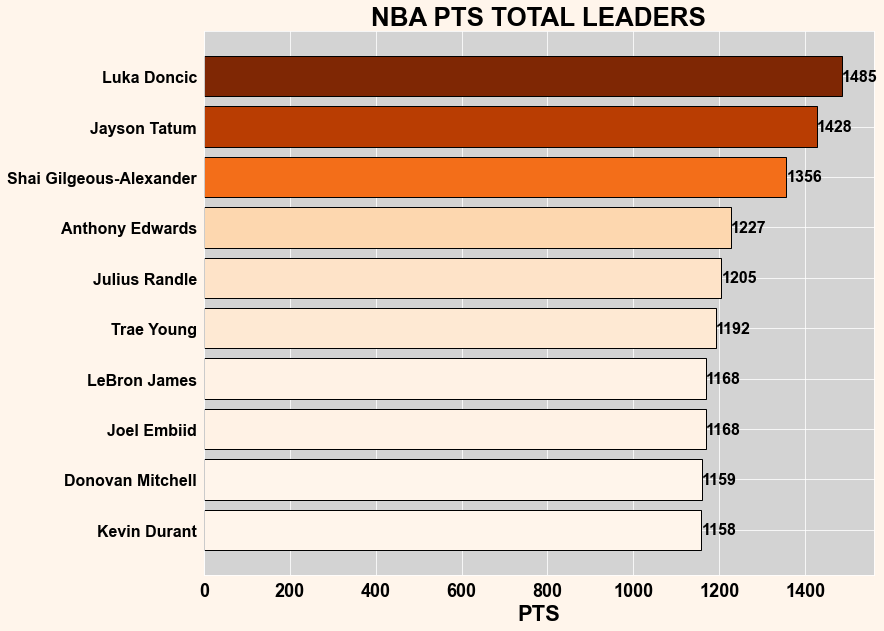

In [58]:
def player_total_leaders(stat, pal, num=10):
    
    if num<=10: figheight=num
    if num>10 and num>=20: figheight=num*0.9
    if num>20 and num>=30: figheight=num*0.8
    if num>30 and num>=40: figheight=num*0.7
    if num>40 and num>=50: figheight=num*0.6
    if num>50: figheight=num*0.5
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, figheight))
    
    my_cmap = plt.get_cmap(f"{pal}")
    rescale = lambda y: (y*1.0 - np.min(y)) / (np.max(y) - np.min(y))
    
    x = df_player_totals.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(num).sort_values(f'{stat}',ascending=True).PLAYER_NAME
    y = df_player_totals.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(num).sort_values(f'{stat}',ascending=True)[f'{stat}']
    
    ax.barh(x,y,color=my_cmap(rescale(y)), edgecolor='black')
    ax.bar_label(ax.containers[0], fontsize=16, fontweight='bold', fmt = '%.0f', color='black')
    
    plt.xticks(fontsize=18, fontweight='bold', color='black')
    plt.xlabel(f'{stat}', fontsize=22, fontweight='bold', color='black')

    plt.yticks(fontsize=16, fontweight='bold', color='black')
    
    plt.title(f"NBA {stat} TOTAL LEADERS", fontsize=26, fontweight='bold', color='black')
    
    ax.set_facecolor('lightgrey')
    fig.set_facecolor(my_cmap(0))
    
    # TODO: Change label and tick color based on face color
    
    plt.show()
    
player_total_leaders('PTS', "Oranges", num=10)

## Distribution Histogram Plotting Functions

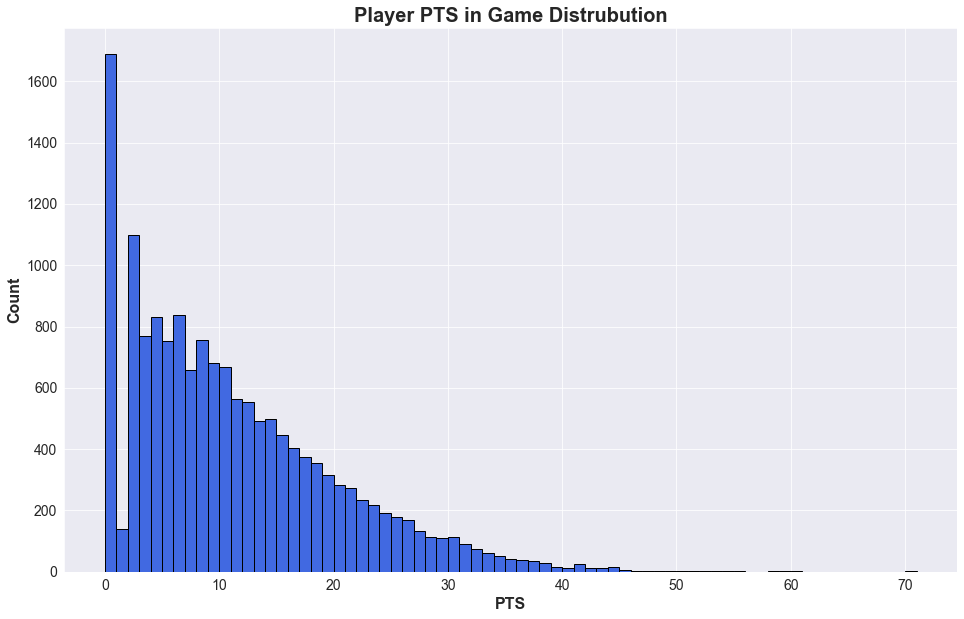

In [59]:
def player_stat_count_hist(stat, color='royalblue'):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
    
    x=df_players[stat]

    ax = plt.hist(x, bins=np.max(df_players[stat]), color=color, edgecolor='black')

    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.ylabel('Count', fontsize=16, fontweight='bold')
    plt.xlabel(stat, fontsize=16, fontweight='bold')
    
    plt.title(f'Player {stat} in Game Distrubution', fontsize=20, fontweight='bold')
    
    plt.show()
    
player_stat_count_hist('PTS')

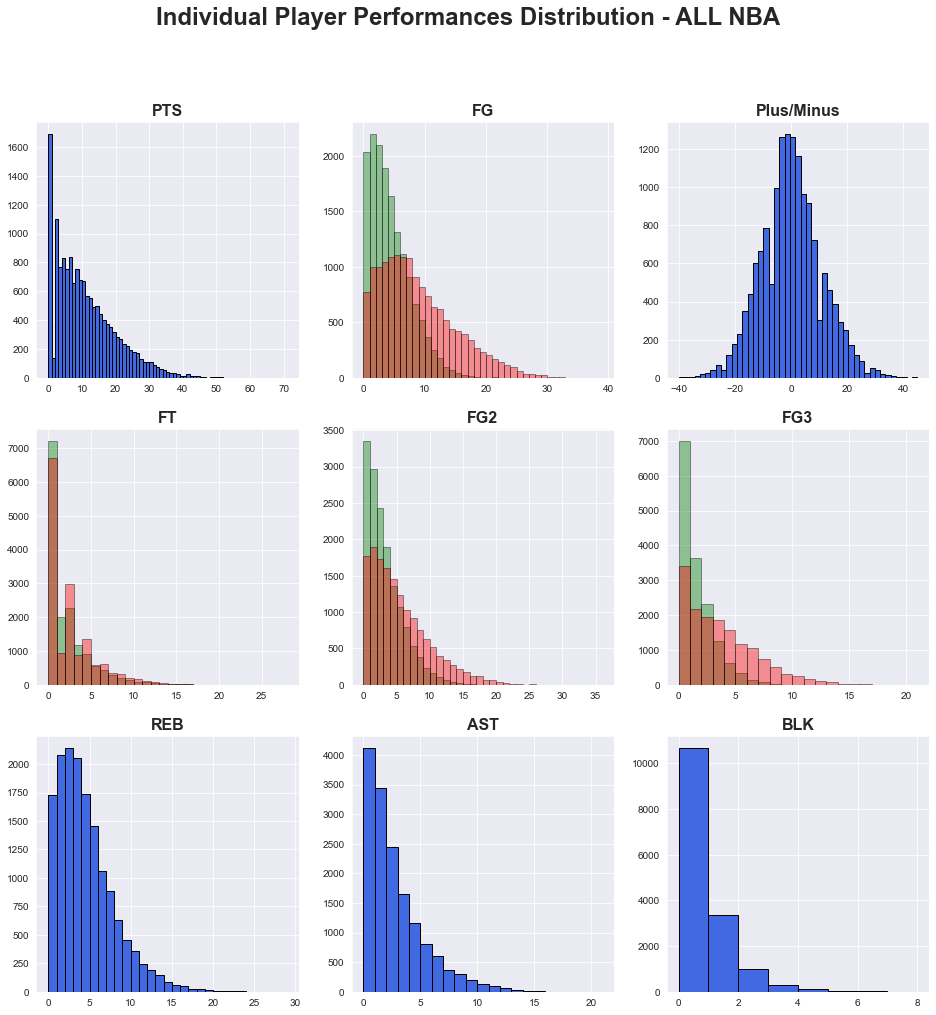

In [60]:
# Reprogram this into for loop later

def player_stat_count_hist9():
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
    
    ax[0,0].hist(df_players['PTS'], bins=np.max(df_players['PTS']), color='royalblue', edgecolor='black')
    ax[0,0].set_title('PTS', fontsize=16, fontweight='bold')
    
    ax[0,1].hist(df_players['FGM'], bins=np.max(df_players['FGM']),alpha=0.4, color='green', edgecolor='black')
    ax[0,1].hist(df_players['FGA'], bins=np.max(df_players['FGA']),alpha=0.4, color='red', edgecolor='black')
    ax[0,1].set_title('FG', fontsize=16, fontweight='bold')
    
    ax[0,2].hist(df_players['PLUS_MINUS'], bins=np.max(df_players['PLUS_MINUS']), color='royalblue', edgecolor='black')
    ax[0,2].set_title('Plus/Minus', fontsize=16, fontweight='bold')
    
    ax[1,0].hist(df_players['FTM'], bins=np.max(df_players['FTM']),alpha=0.4, color='green', edgecolor='black')
    ax[1,0].hist(df_players['FTA'], bins=np.max(df_players['FTA']),alpha=0.4, color='red', edgecolor='black')
    ax[1,0].set_title('FT', fontsize=16, fontweight='bold')
    
    ax[1,1].hist(df_players['FG2M'], bins=np.max(df_players['FG2M']),alpha=0.4, color='green', edgecolor='black')
    ax[1,1].hist(df_players['FG2A'], bins=np.max(df_players['FG2A']),alpha=0.4, color='red', edgecolor='black')
    ax[1,1].set_title('FG2', fontsize=16, fontweight='bold')
    
    ax[1,2].hist(df_players['FG3M'], bins=np.max(df_players['FG3M']),alpha=0.4, color='green', edgecolor='black')
    ax[1,2].hist(df_players['FG3A'], bins=np.max(df_players['FG3A']),alpha=0.4, color='red', edgecolor='black')
    ax[1,2].set_title('FG3', fontsize=16, fontweight='bold')
    
    ax[2,0].hist(df_players['REB'], bins=np.max(df_players['REB']), color='royalblue', edgecolor='black')
    ax[2,0].set_title('REB', fontsize=16, fontweight='bold')
    
    ax[2,1].hist(df_players['AST'], bins=np.max(df_players['AST']), color='royalblue', edgecolor='black')
    ax[2,1].set_title('AST', fontsize=16, fontweight='bold')
    
    ax[2,2].hist(df_players['BLK'], bins=np.max(df_players['BLK']), color='royalblue', edgecolor='black')
    ax[2,2].set_title('BLK', fontsize=16, fontweight='bold')
    
    # Field goal double hist? Same for 3s?
    
    fig.suptitle('Individual Player Performances Distribution - ALL NBA', fontsize=24, fontweight='bold')
    
    plt.show()
    
player_stat_count_hist9()

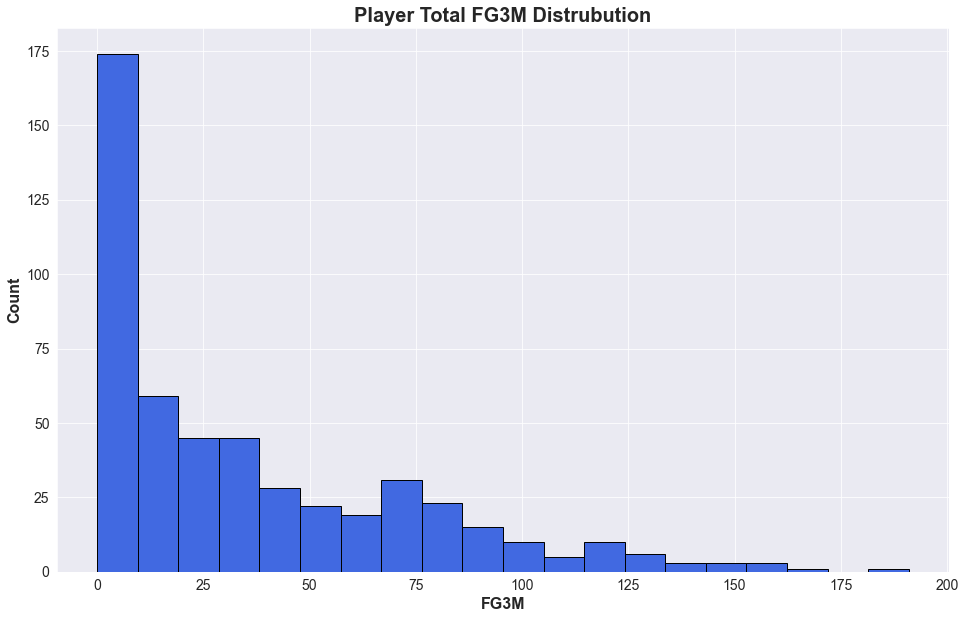

In [61]:
def player_stat_total_hist(stat, bins=20, color='royalblue'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

    dist=df_player_totals[stat]
    
    ax.hist(dist, bins=bins, color=color, edgecolor='black')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.ylabel('Count', fontsize=16, fontweight='bold')
    plt.xlabel(stat, fontsize=16, fontweight='bold')
    
    plt.title(f'Player Total {stat} Distrubution', fontsize=20, fontweight='bold')
    
    plt.show()
    
player_stat_total_hist('FG3M')

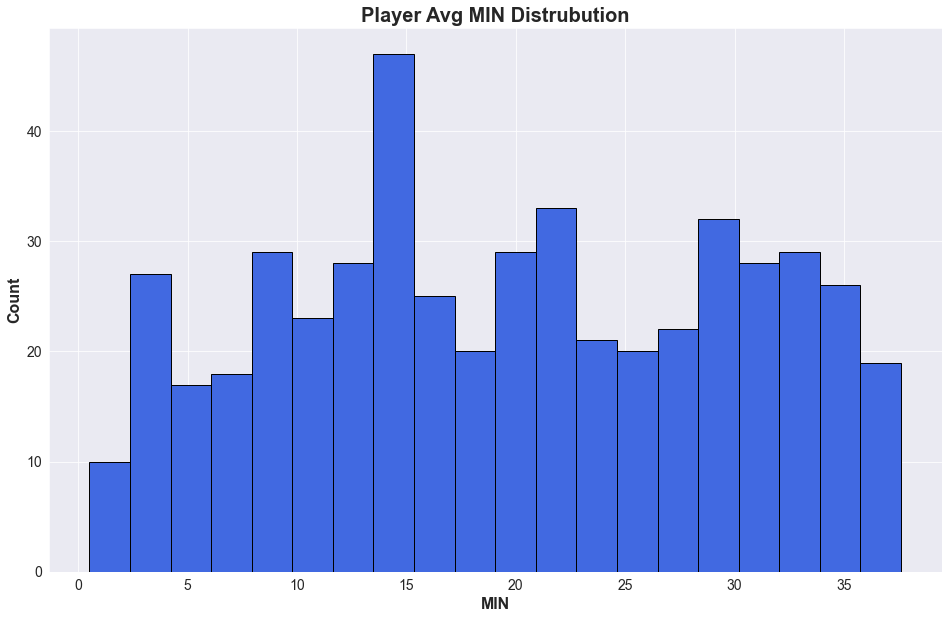

In [62]:
def player_stat_avg_hist(stat, bins=20, color='royalblue'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

    dist=df_player_avg[stat]

    ax.hist(dist, bins=bins, color=color, edgecolor='black')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.ylabel('Count', fontsize=16, fontweight='bold')
    plt.xlabel(stat, fontsize=16, fontweight='bold')
    
    plt.title(f'Player Avg {stat} Distrubution', fontsize=20, fontweight='bold')
    
    plt.show()
    
player_stat_avg_hist('MIN')

## NBA Leaders Report Function

In [63]:
def nba_leaders():
    player_avg_leaders('PTS', 'Greens')
    print()
    player_total_leaders('PTS', 'Greens')
    print()
    player_avg_leaders('REB', 'Blues')
    print()
    player_total_leaders('REB', 'Blues')
    print()
    player_avg_leaders('AST', 'Purples')
    print()
    player_total_leaders('AST', 'Purples')
#nba_leaders()

## Player Report Function

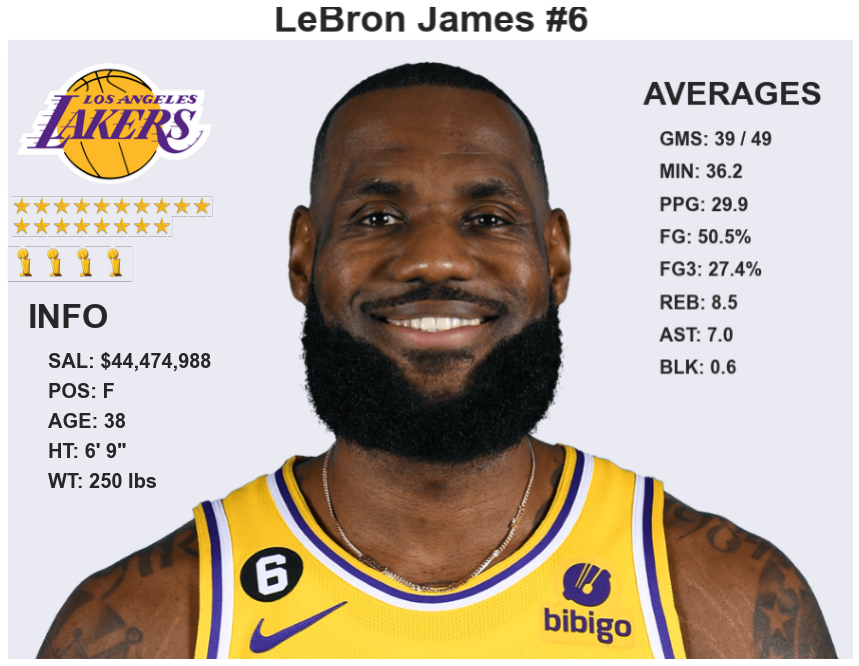

Professional Summary
Four-time NBA Champion (2012, 2013, 2016, 2020) … Four-time NBA Most Valuable Player (2009, 2010, 2012, 2013) … Four-time NBA Finals MVP (2012, 2013, 2016, 2020) … NBA Rookie of the Year (2003) and unanimous All-Rookie First Team selection … Helped lead the United States to gold medals at the 2008 Beijing and 2012 London Olympics and to a bronze medal at the 2004 Athens Olympics … 15-time All-NBA honoree (First Team in 2006, 2008-18; Second Team in 2005 and 2007; Third Team in 2019) … Has been named to the NBA’s All-Defensive Team six times (First Team in 2009-13; Second Team in 2014) … Signed as a free agent with the Los Angeles Lakers on July 9, 2018 … became the first pair of teammates (alongside Anthony Davis) in NBA history to average 25 points while shooting 50 percent from the field in a  single postseason (min. 6 games), and the fourth to do so in the Finals (S. O’Neal/K. Bryant, 2002; S. O’Neal/P. Hardaway, 1995; J. Erving/A. Toney, 1982) … joined Robert H

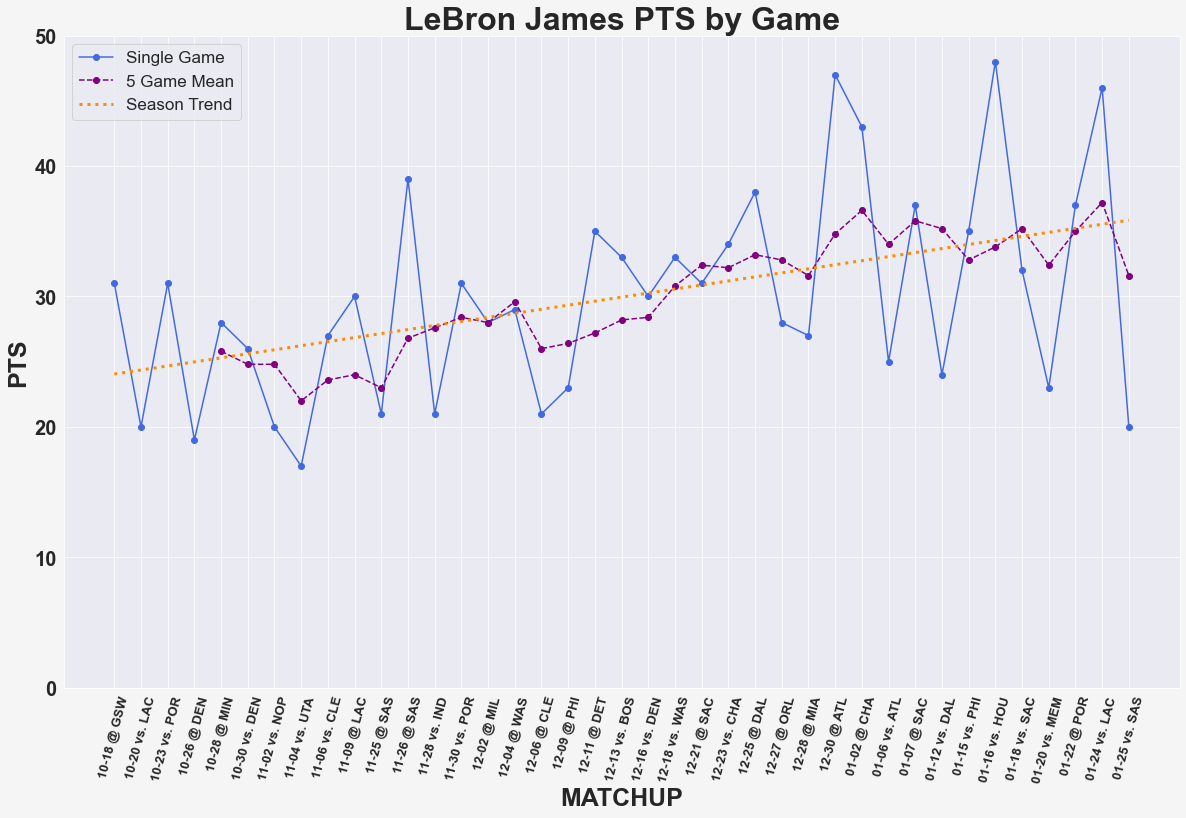

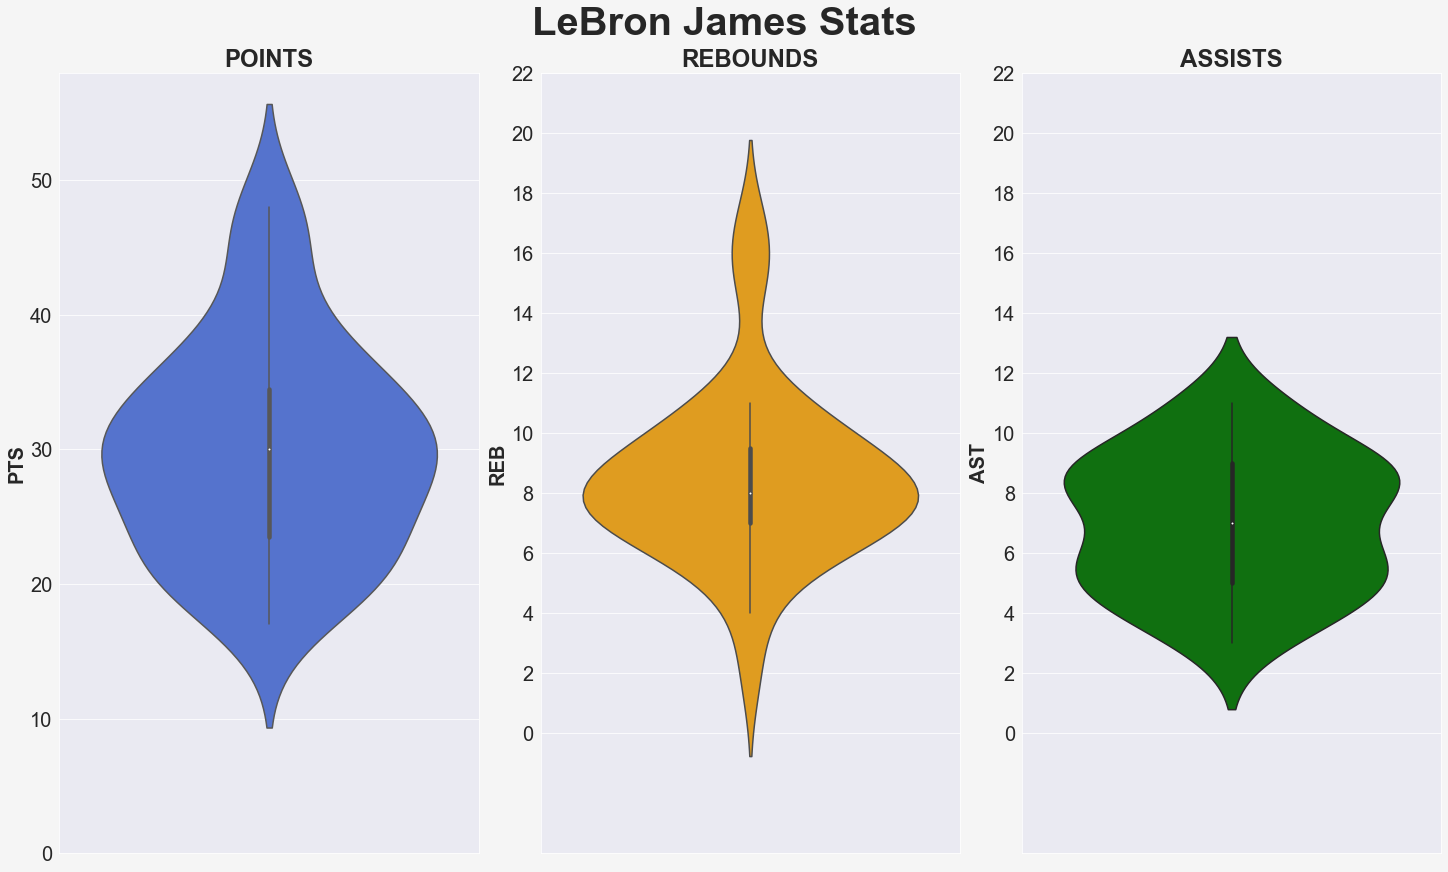

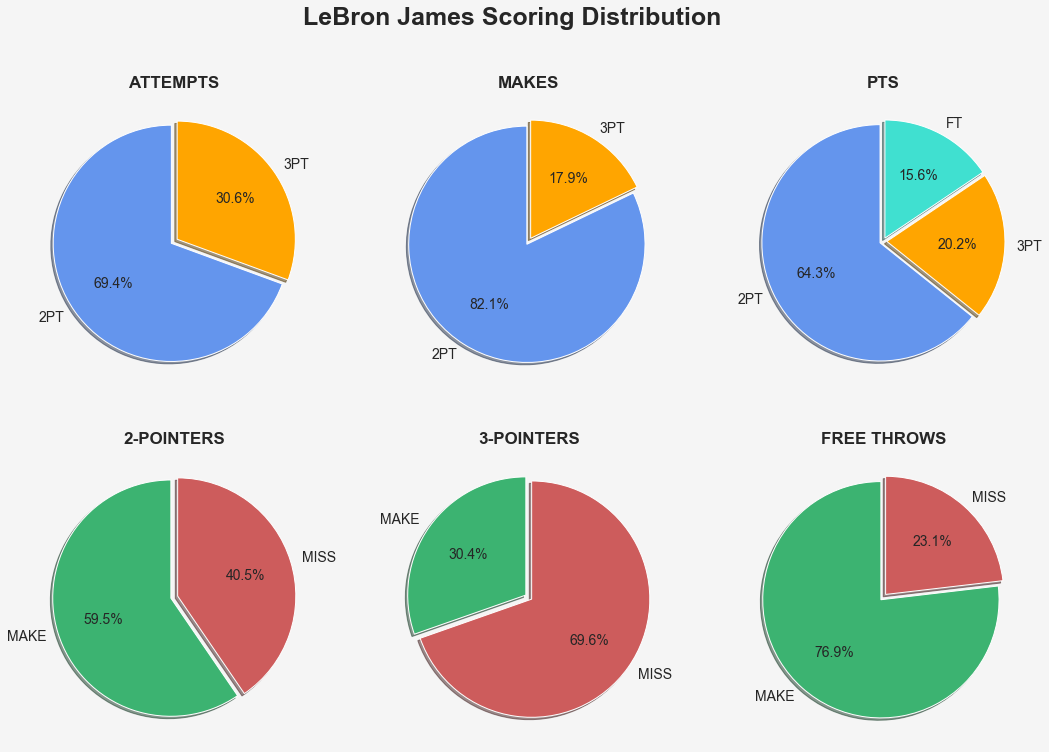

In [65]:
def player_report(player_id):
    display_player_image(player_id)
    try:
        career_summary(df_players[df_players.PLAYER_ID == player_id].PLAYER_NAME.unique().item().strip())
    except: pass
    if df_players[df_players.PLAYER_ID==player_id].PTS.count() > 0:
        player_stat_plot(df_players[df_players.PLAYER_ID==player_id].PLAYER_NAME.unique().item(), 'PTS')
        try:
            if df_players[df_players.PLAYER_ID==player_id].AST.count() > 0 and df_players[df_players.PLAYER_ID==player_id].REB.count() > 0:
                player_pra_violins(df_players[df_players.PLAYER_ID==player_id].PLAYER_NAME.unique().item())
        except: pass
        try:
            player_shooter_pies(df_players[df_players.PLAYER_ID==player_id].PLAYER_NAME.unique().item())
        except: pass
player_report(lebron_id)

## Roster Summary Function: Player reports for an entire team

In [67]:
def display_roster_summary(team_abbr):
    for i in df_player_avg[df_player_avg['TEAM_ABBREVIATION']==team_abbr].sort_values('PTS',ascending=False).reset_index(drop=True).PLAYER_ID.unique():
        player_report(i)
        print()
        print('------------------------------------------------------------------------------------------------------------------')
        print()
#display_roster_summary('MIL')